# Chapter 9 - Nonstationarity and Cointegrations

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from PythonTsa.RandomWalk import RandomWalk_with_drift
from PythonTsa.plot_acf_pacf import acf_pacf_fig
from PythonTsa.LjungBoxtest import plot_LB_pvalue
import statsmodels.api as sm
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.graphics.tsaplots import quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller, kpss, coint
import statsmodels.formula.api as smf
from statsmodels.tsa.vector_ar.vecm import VECM,  select_coint_rank, select_order
from PythonTsa.plot_multi_ACF import multi_ACFfig
from PythonTsa.plot_multi_Q_pvalue import MultiQpvalue_plot

In [4]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

## A Time Series with Trend Components

In [6]:
# Set a random seed for reproducibility
np.random.seed(1373)  

# Generate a random walk with drift:
rw0 = RandomWalk_with_drift(drift=0.0,    # No drift (0.0)
                            nsample=250,  # Number of samples = 250
                            burnin=10)    # Burn-in period of 10 observations

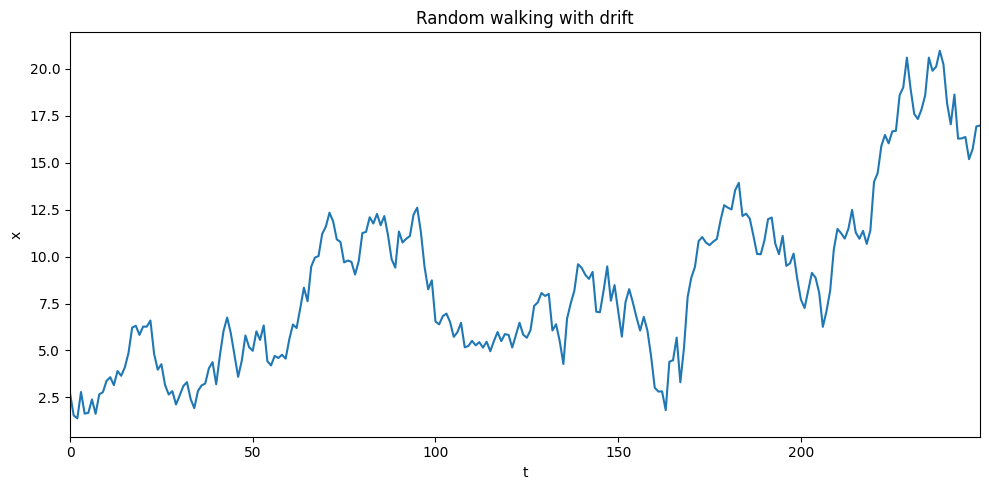

In [7]:
# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(rw0)
plt.xlabel('t')
plt.ylabel('x')
plt.title('Random walking with drift')
plt.xlim(0, 249)
plt.tight_layout()
plt.show()

In [8]:
# Create a time index from 1 to the length of the random walk series
t = np.arange(1, len(rw0) + 1)  

# Generate a synthetic dataset using a linear trend and the random walk:
Mydata = 0.3 + 0.2 * t + rw0  # Trend component (0.3 + 0.2*t) + random walk noise (rw0)

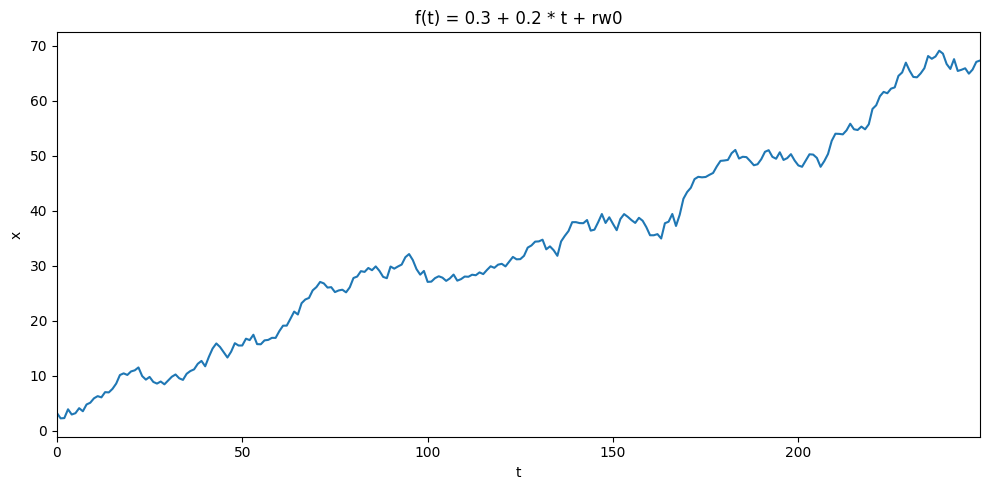

In [9]:
# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(Mydata)
plt.xlabel('t')
plt.ylabel('x')
plt.title('f(t) = 0.3 + 0.2 * t + rw0')
plt.xlim(0, 249)
plt.tight_layout()
plt.show()

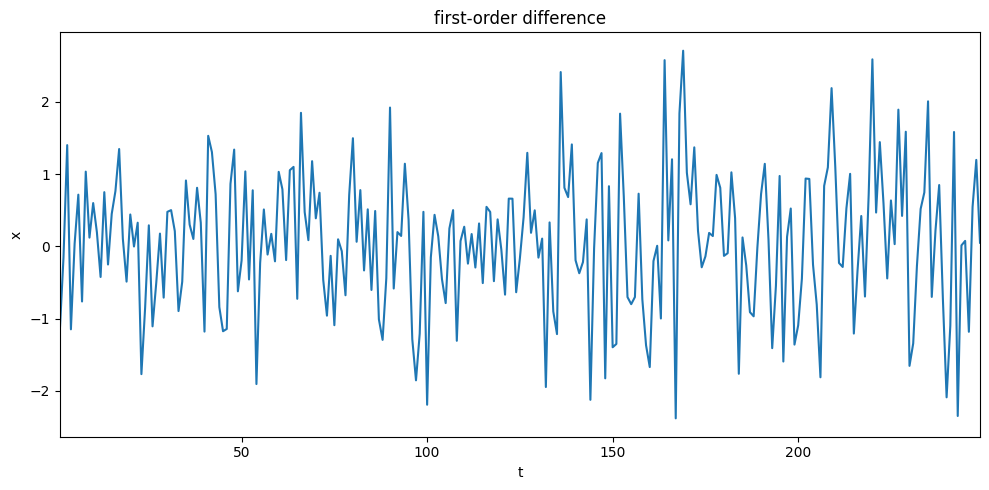

In [10]:
# Compute the first-order difference of the random walk series
drw = rw0.diff(1).dropna() 

# Plot graph
plt.figure(figsize=(10, 5))
plt.plot(drw)
plt.xlabel('t')
plt.ylabel('x')
plt.title('first-order difference')
plt.xlim(1, 249)
plt.tight_layout()
plt.show()

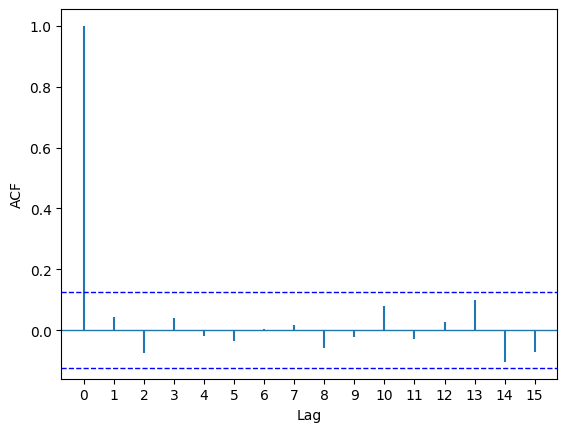

In [11]:
# Plot the Autocorrelation Function (ACF) of the differenced random walk series
acf_pacf_fig(drw,        # Input data (differenced random walk)
             both=False, # Plot only ACF (not PACF)
             lag=15)     # Number of lags to display

## Stochastic Trend in Closing Price Series of IBM Stock

In [13]:
url2 =('https://raw.githubusercontent.com/QuantLet/pyTSA/refs/heads/main/pyTSA_TrendIBM/IBM.csv')

IBM = pd.read_csv(url2, header = 0)

IBM

,Date,Open,High,Low,Close,Adj Close,Volume
0,1966/1/1,8.291667,8.558333,7.866667,8.266666,0.672670,12648000
1,1966/2/1,8.266666,8.745833,8.133333,8.583333,0.698438,8011200
2,1966/3/1,8.583333,8.750000,8.241667,8.600000,0.700003,9123200
3,1966/4/1,8.600000,9.366667,8.566667,9.291667,0.756301,7316800
4,1966/5/1,9.291667,9.350000,8.600000,9.068750,0.738157,10494400
...,...,...,...,...,...,...,...
646,2019/11/1,134.500000,139.139999,132.750000,134.449997,131.507324,64772300
647,2019/12/1,134.449997,136.419998,130.690002,134.039993,132.654785,71853900
648,2020/1/1,135.000000,145.789993,133.199997,143.729996,142.244659,113249700
649,2020/2/1,144.250000,158.750000,126.360001,130.149994,128.804993,118150200


In [14]:
# Convert the 'Date' column to datetime format
IBM['Date'] = pd.to_datetime(IBM['Date'])

# Set the 'Date' column as the index of the DataFrame
IBM.index = IBM['Date']

# Extract the 'Close' column into a separate Series
IBMclose = IBM['Close']

In [15]:
IBMclose

Date
1966-01-01      8.266666
1966-02-01      8.583333
1966-03-01      8.600000
1966-04-01      9.291667
1966-05-01      9.068750
                 ...    
2019-11-01    134.449997
2019-12-01    134.039993
2020-01-01    143.729996
2020-02-01    130.149994
2020-03-01    105.480003
Name: Close, Length: 651, dtype: float64

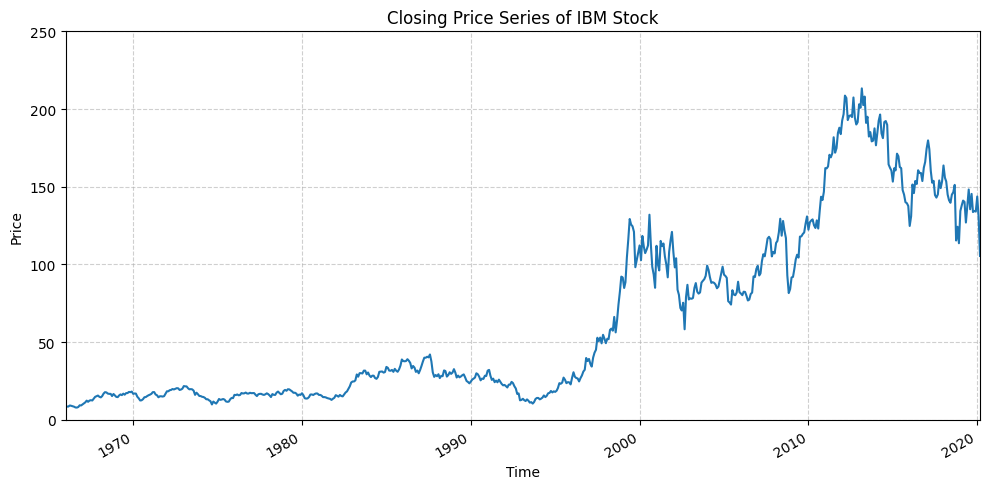

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(IBMclose)
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_title('Closing Price Series of IBM Stock')
ax.set_xlim(pd.to_datetime('1966-01-01'), pd.to_datetime('2020-03-01'))
ax.set_ylim(0,250)
ax.grid(True, linestyle='--', alpha=0.6)  

fig.autofmt_xdate()
plt.tight_layout()

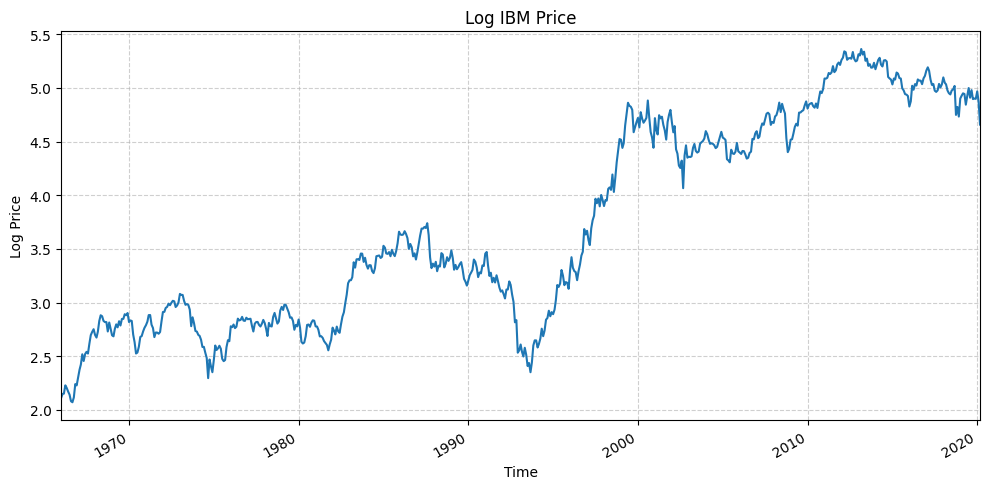

In [17]:
# Take the natural logarithm of the 'IBMclose' time series
LIBMclose = np.log(IBMclose)

# Plot Graph
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(LIBMclose)
ax.set_xlabel('Time')
ax.set_ylabel('Log Price')
ax.set_title('Log IBM Price')
ax.set_xlim(pd.to_datetime('1966-01-01'), pd.to_datetime('2020-03-01'))
ax.grid(True, linestyle='--', alpha=0.6)  

fig.autofmt_xdate()
plt.tight_layout()

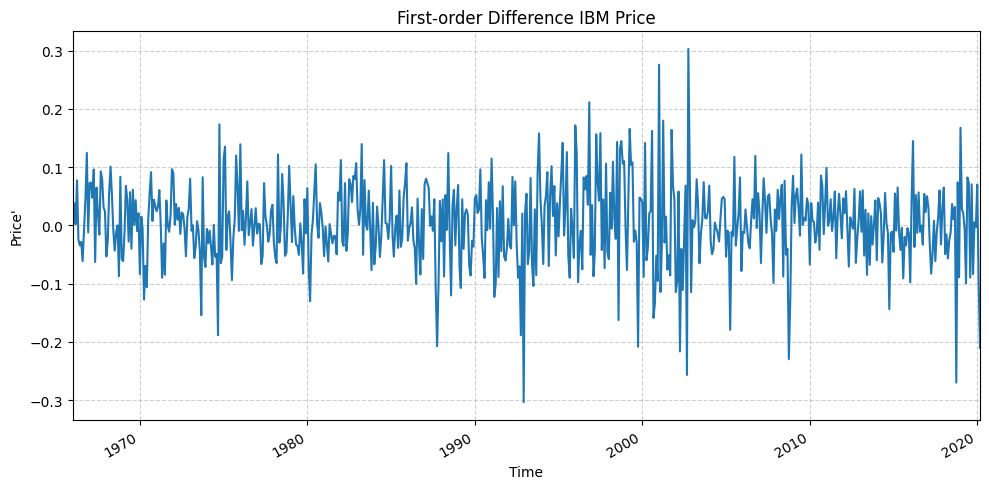

In [18]:
# Compute the first-order difference of the log-transformed 'IBMclose' time series
dLIBMclose = LIBMclose.diff(1).dropna()

# Plot Graph
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(dLIBMclose)
ax.set_xlabel('Time')
ax.set_ylabel("Price'")
ax.set_title('First-order Difference IBM Price')
ax.set_xlim(pd.to_datetime('1966-01-01'), pd.to_datetime('2020-03-01'))
ax.grid(True, linestyle='--', alpha=0.6)  

fig.autofmt_xdate()
plt.tight_layout()

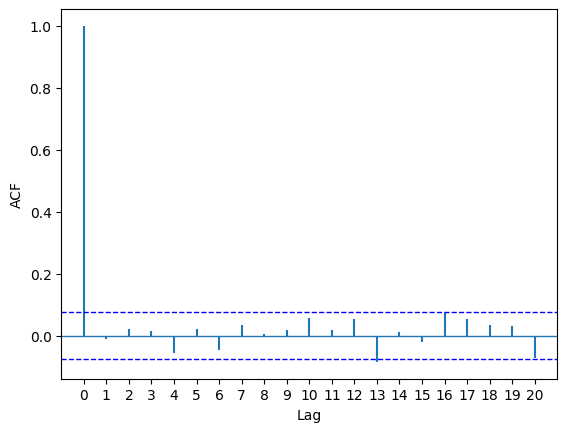

In [19]:
# Plot the ACF and PACF for the differenced log of IBM closing prices
acf_pacf_fig(dLIBMclose,   # The differenced log-transformed IBM closing prices
             both=False,   # Plot only ACF (not PACF)
             lag=20)       # Number of lags to display

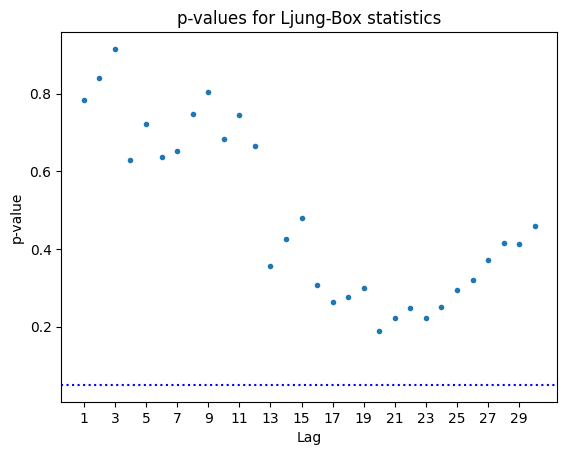

In [20]:
# Plot the Ljung-Box p-values for the differenced log of IBM closing prices
plot_LB_pvalue(dLIBMclose,        # The differenced log-transformed IBM closing prices
               noestimatedcoef=0, # No estimated coefficients (for degrees of freedom adjustment)
               nolags=30)         # Number of lags to test autocorrelation up to 30

## Stationary Seasonal AR(1) Processes and Seasonal Random Walk

### Seasonal Random Walk

The **ordinary random walk** is defined as:

$$
X_t = X_{t-1} + \varepsilon_t
$$

where $ \varepsilon_t \sim WN(0, \sigma^2) $ represents white noise with mean zero and variance $ \sigma^2 $.

The **seasonal random walk** extends this concept by incorporating a seasonal lag $ p $, such that:

$$
X_t = X_{t-p} + \varepsilon_t
$$

where $ p > 1 $ is the seasonal period and $ \varepsilon_t \sim WN(0, \sigma^2) $.


In [23]:
sar1 = np.array([1, 0, 0, 0, -0.2])
sar2 = np.array([1, 0, 0, 0, -0.6])
sar3 = np.array([1, 0, 0, 0, -0.8])
sar4 = np.array([1, 0, 0, 0, -1.0])

np.random.seed(137)

x1 = arma_generate_sample(ar = sar1, ma = [1], nsample = 200)
x2 = arma_generate_sample(ar = sar2, ma = [1], nsample = 200)
x3 = arma_generate_sample(ar = sar3, ma = [1], nsample = 200)
x4 = arma_generate_sample(ar = sar4, ma = [1], nsample = 200)

x1 = pd.Series(x1)
x2 = pd.Series(x2)
x3 = pd.Series(x3)
x4 = pd.Series(x4)

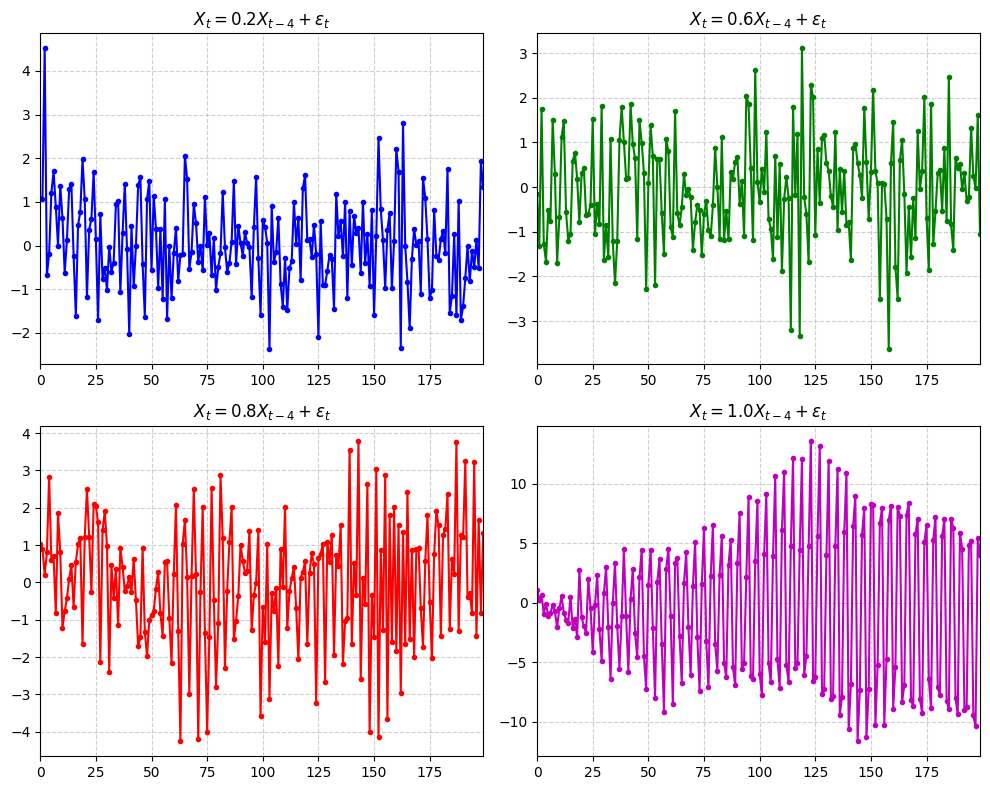

In [24]:
# Create a figure with 2x2 subplots and set figure size
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plot x1
axes[0, 0].plot(x1, marker='.', linestyle='-', color='b')
axes[0, 0].set_title(r'$X_t = 0.2X_{t-4} + \epsilon_t$')
axes[0, 0].grid(True, linestyle='--', alpha=0.6)
axes[0, 0].set_xlim(0, 199)

# Plot x2
axes[0, 1].plot(x2, marker='.', linestyle='-', color='g')
axes[0, 1].set_title(r'$X_t = 0.6X_{t-4} + \epsilon_t$')
axes[0, 1].grid(True, linestyle='--', alpha=0.6)
axes[0, 1].set_xlim(0, 199)

# Plot x3
axes[1, 0].plot(x3, marker='.', linestyle='-', color='r')
axes[1, 0].set_title(r'$X_t = 0.8X_{t-4} + \epsilon_t$')
axes[1, 0].grid(True, linestyle='--', alpha=0.6)
axes[1, 0].set_xlim(0, 199)

# Plot x4
axes[1, 1].plot(x4, marker='.', linestyle='-', color='m')
axes[1, 1].set_title(r'$X_t = 1.0X_{t-4} + \epsilon_t$')
axes[1, 1].grid(True, linestyle='--', alpha=0.6)
axes[1, 1].set_xlim(0, 199)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

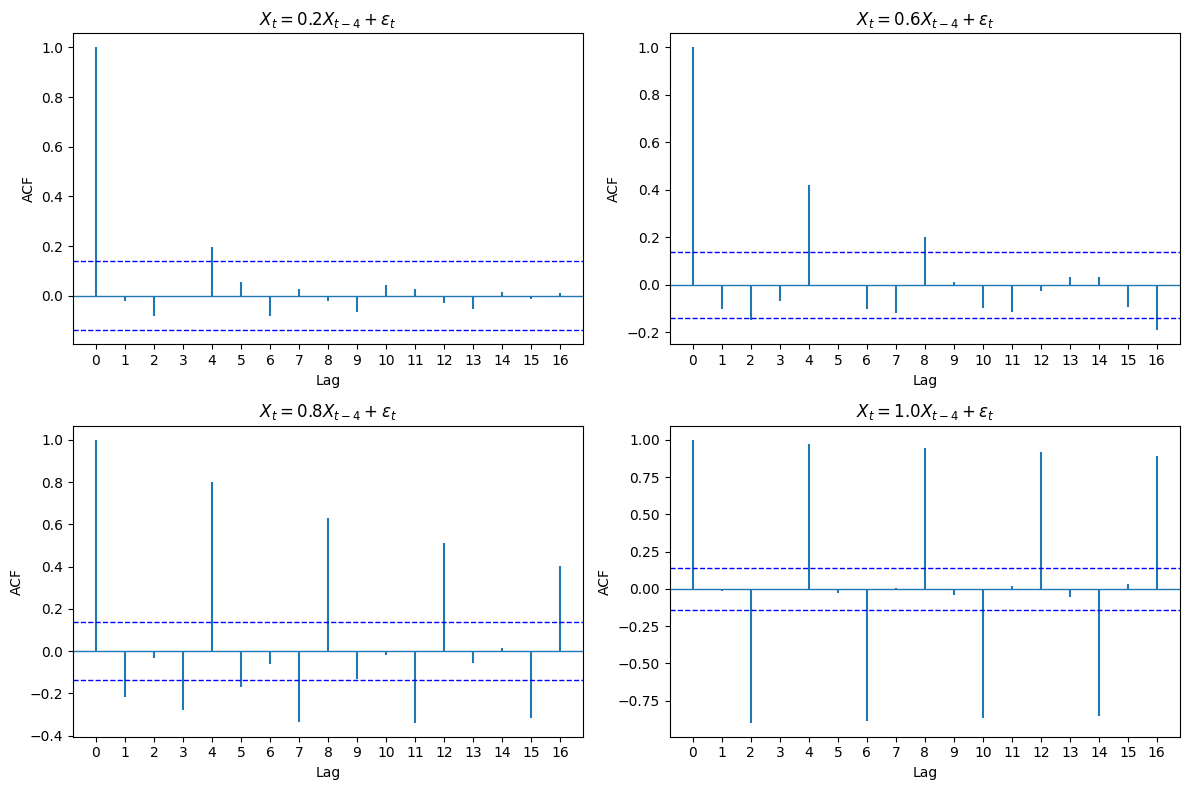

In [25]:
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(221)
acf_pacf_fig(x1, both = False, lag = 16)
plt.title('$X_t = 0.2X_{t-4}+\epsilon_t$')

ax = fig.add_subplot(222)
acf_pacf_fig(x2, both = False, lag = 16)
plt.title('$X_t = 0.6X_{t-4}+\epsilon_t$')

ax = fig.add_subplot(223)
acf_pacf_fig(x3, both = False, lag = 16)
plt.title('$X_t = 0.8X_{t-4}+\epsilon_t$')

ax = fig.add_subplot(224)
acf_pacf_fig(x4, both = False, lag = 16)
plt.title('$X_t = 1.0X_{t-4}+\epsilon_t$')

plt.tight_layout()
plt.show()

In [26]:
speriod = pd.date_range('2001-01', periods = len(x1), freq = 'QE')

x1.index = speriod
x2.index = speriod
x3.index = speriod
x4.index = speriod

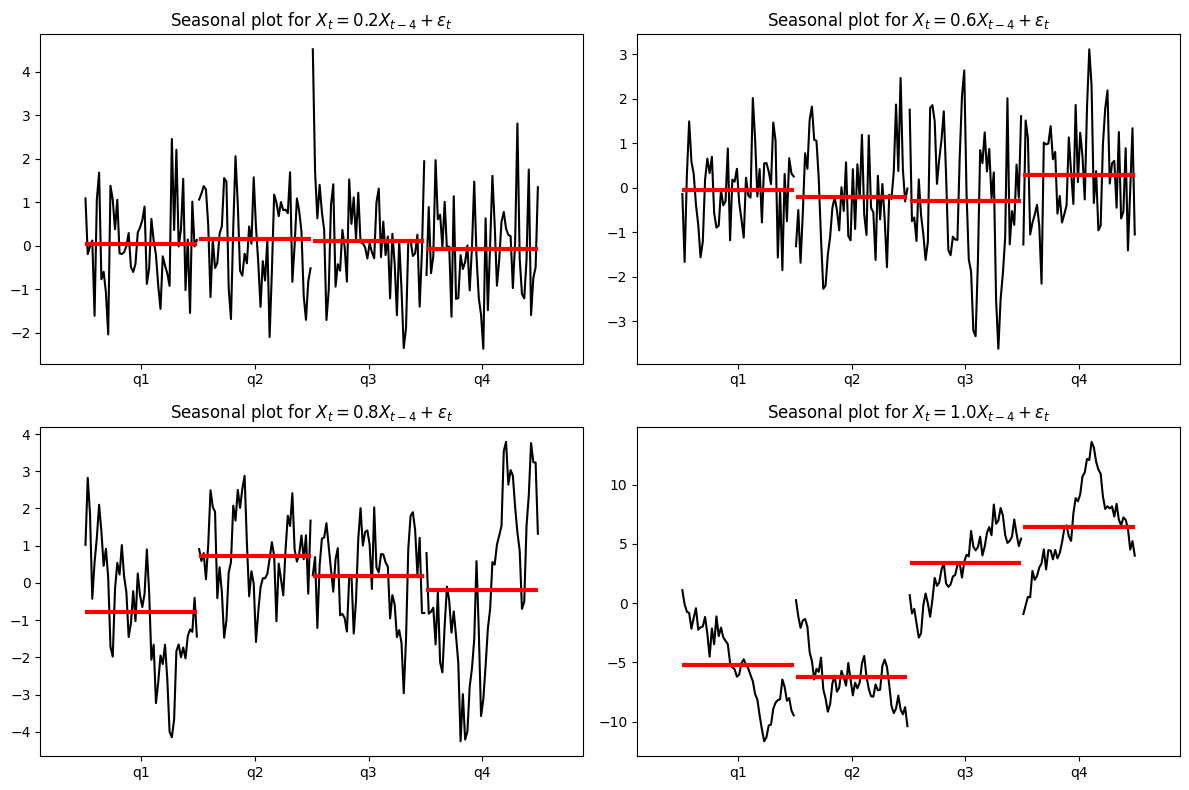

In [27]:
fig = plt.figure(figsize=(12, 8))

quarter_plot(x1, ax = fig.add_subplot(221))
plt.title('Seasonal plot for $X_t = 0.2X_{t-4}+\epsilon_t$')

quarter_plot(x2, ax = fig.add_subplot(222))
plt.title('Seasonal plot for $X_t = 0.6X_{t-4}+\epsilon_t$')

quarter_plot(x3, ax = fig.add_subplot(223))
plt.title('Seasonal plot for $X_t = 0.8X_{t-4}+\epsilon_t$')

quarter_plot(x4, ax = fig.add_subplot(224))
plt.title('Seasonal plot for $X_t = 1.0X_{t-4}+\epsilon_t$')

plt.tight_layout()
plt.show()

In [28]:
# Reshapes the time series into a seasonal matrix where each column represents a season

# Create an empty DataFrame with rows based on one-fourth the length of x1
y = pd.DataFrame(index=range(0, int(len(x1)/4)), columns=['0', '1', '2', '3'])

# Loop over the 4 different phases (seasonal components)
for i in range(0, 4):  
    for j in range(i, len(x1), 4):  
        y.iat[int(j/4), i] = x1[j]  # Assign values from x1 to the corresponding column

# Flatten the DataFrame by concatenating the columns into a single Series
z = pd.concat([y['0'], y['1'], y['2'], y['3']], ignore_index=True) 

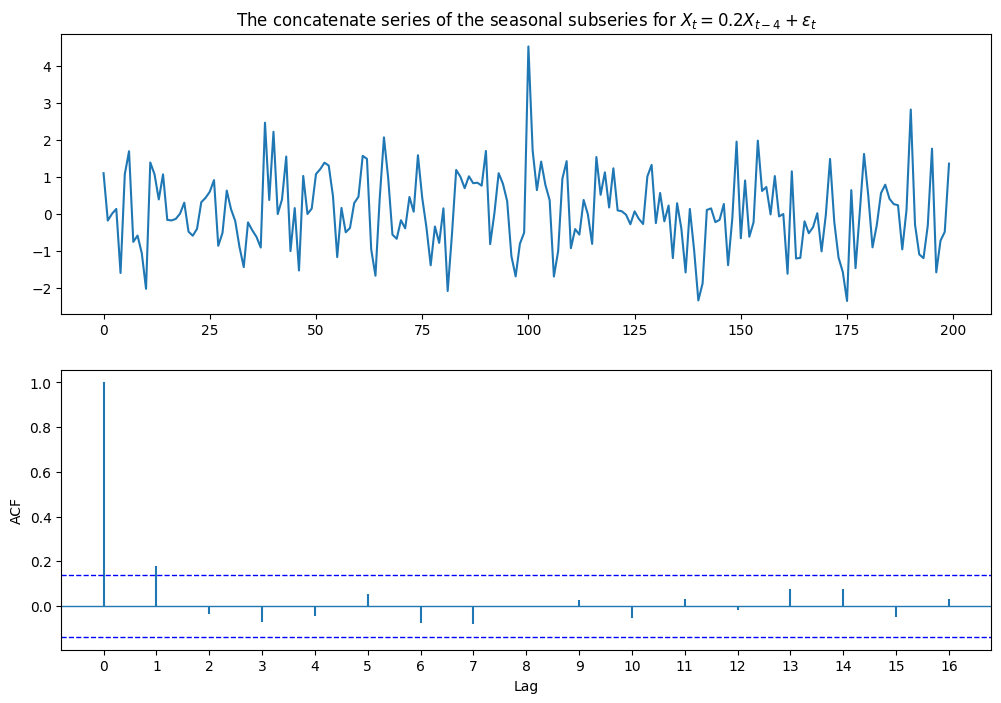

In [29]:
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(211)
z.plot()
plt.title('The concatenate series of the seasonal subseries for $X_t = 0.2X_{t-4}+\epsilon_t$')

ax = fig.add_subplot(212)
acf_pacf_fig(z, both = False, lag = 16)

In [30]:
# Reshapes the time series into a seasonal matrix where each column represents a season

# Create an empty DataFrame for seasonal random walk (SRW) with 4 columns
srw = pd.DataFrame(index=range(0, int(len(x1)/4)), 
                   columns=['0', '1', '2', '3'])

# Loop through the 4 seasonal components
for i in range(0, 4):
    for j in range(i, len(x4), 4):  
        srw.iat[int(j/4), i] = x4[j]  # Assign values from x4 based on seasonal index

# Concatenate the columns to restore a single time series in a reshuffled order
csrw = pd.concat([srw['0'], srw['1'], srw['2'], srw['3']], ignore_index=True)

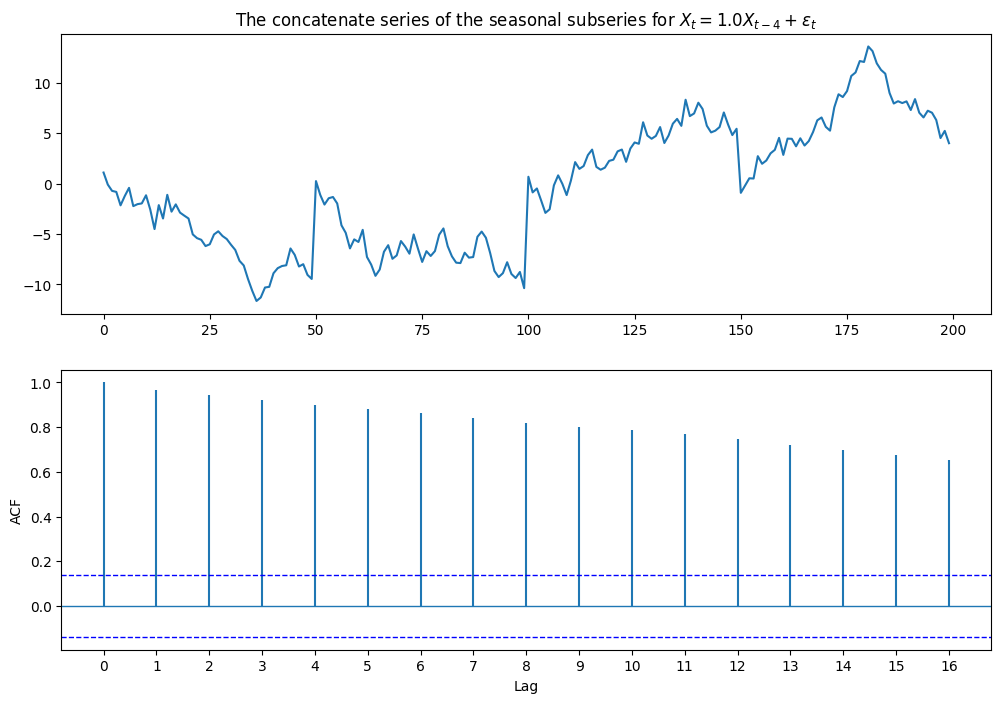

In [31]:
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(211)
csrw.plot()
plt.title('The concatenate series of the seasonal subseries for $X_t = 1.0X_{t-4}+\epsilon_t$')

ax = fig.add_subplot(212)
acf_pacf_fig(csrw, both = False, lag = 16)

## Deterministic and Stochastic Seasonality in the US Quarterly NotSeasonally-Adjusted GDP Series

In [33]:
url4 = ('https://raw.githubusercontent.com/QuantLet/pyTSA/refs/heads/main/pyTSA_SeasonalityUSGDP/usGDPnotAdjust.csv')

usgdp = pd.read_csv(url4, header = 0)

usgdp

,DATE,NA000334Q
0,1947-01-01,58497.0
1,1947-04-01,60672.0
2,1947-07-01,62196.0
3,1947-10-01,68250.0
4,1948-01-01,64258.0
...,...,...
294,2020-07-01,5302337.0
295,2020-10-01,5490052.0
296,2021-01-01,5367754.0
297,2021-04-01,5711844.0


In [34]:
timeindex = pd.date_range('1947-01', periods = len(usgdp), freq = 'QS')

usgdp.index = timeindex

usgdp = usgdp['NA000334Q']

usgdp

1947-01-01      58497.0
1947-04-01      60672.0
1947-07-01      62196.0
1947-10-01      68250.0
1948-01-01      64258.0
                ...    
2020-07-01    5302337.0
2020-10-01    5490052.0
2021-01-01    5367754.0
2021-04-01    5711844.0
2021-07-01    5818939.0
Freq: QS-JAN, Name: NA000334Q, Length: 299, dtype: float64

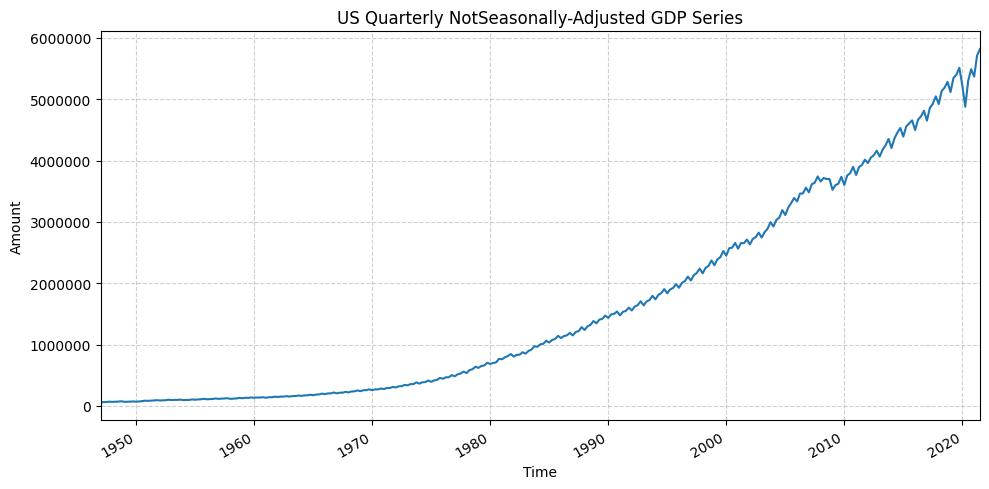

In [35]:
import matplotlib.ticker as mticker

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(usgdp)
ax.set_xlabel('Time')
ax.set_ylabel('Amount')
ax.set_title('US Quarterly NotSeasonally-Adjusted GDP Series')
ax.set_xlim(pd.to_datetime('1947-01-01'), pd.to_datetime('2021-07-01'))
ax.grid(True, linestyle='--', alpha=0.6) 

# Remove scientific notation on y-axis
ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='y') 

fig.autofmt_xdate()
plt.tight_layout()

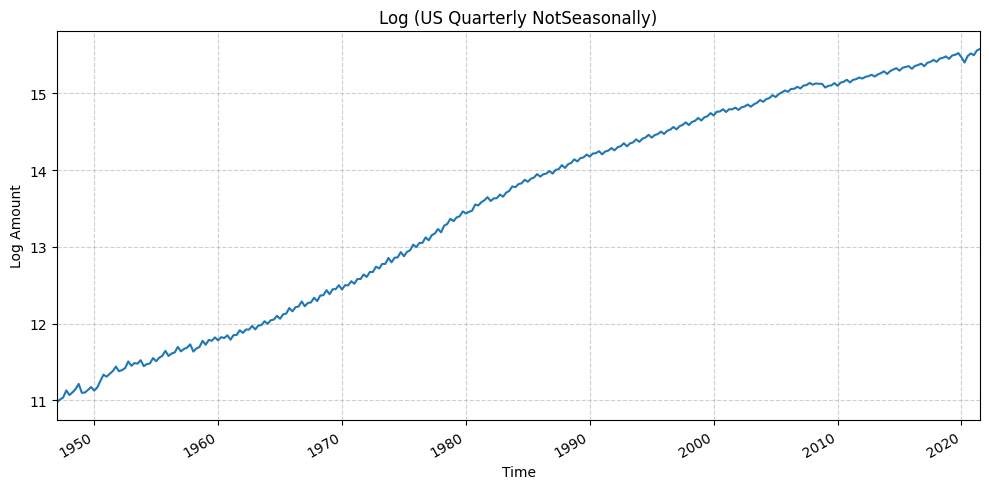

In [36]:
# Take the natural logarithm of the US GDP time series
lusgdp = np.log(usgdp)  

# Rename the series to 'lusGDP' for clarity
lusgdp = lusgdp.rename('lusGDP')  


fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(lusgdp)
ax.set_xlabel('Time')
ax.set_ylabel('Log Amount')
ax.set_title('Log (US Quarterly NotSeasonally)')
ax.set_xlim(pd.to_datetime('1947-01-01'), pd.to_datetime('2021-07-01'))
ax.grid(True, linestyle='--', alpha=0.6) 

# Remove scientific notation on y-axis
#ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
#ax.ticklabel_format(style='plain', axis='y') 

fig.autofmt_xdate()
plt.tight_layout()


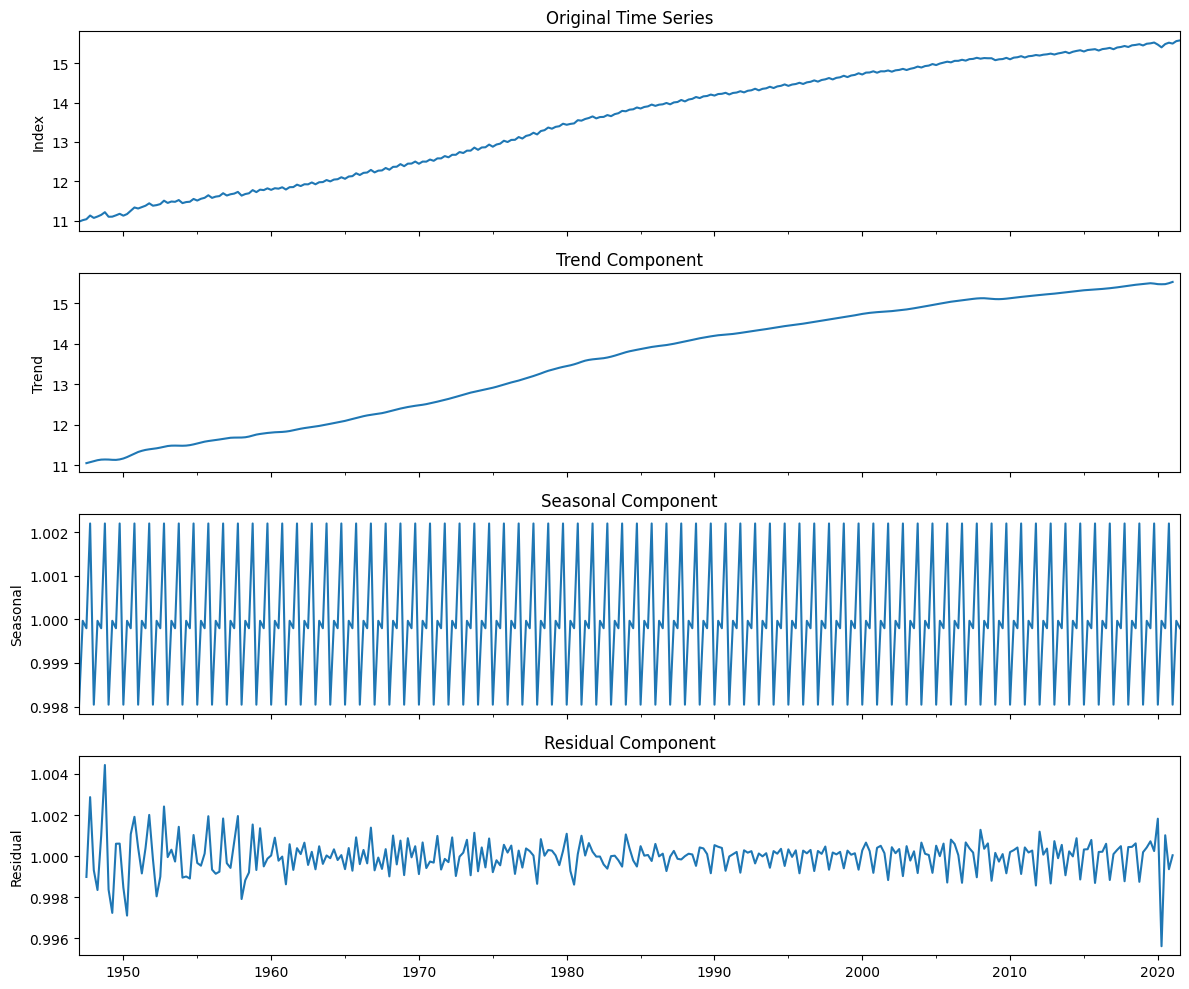

In [37]:
# Perform seasonal decomposition
xdec = seasonal_decompose(lusgdp, model='multiplicative')

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

xdec.observed.plot(ax=axes[0], title="Original Time Series")
axes[0].set_ylabel('Index')

xdec.trend.plot(ax=axes[1], title="Trend Component")
axes[1].set_ylabel('Trend')

xdec.seasonal.plot(ax=axes[2], title="Seasonal Component")
axes[2].set_ylabel('Seasonal')

xdec.resid.plot(ax=axes[3], title="Residual Component")
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

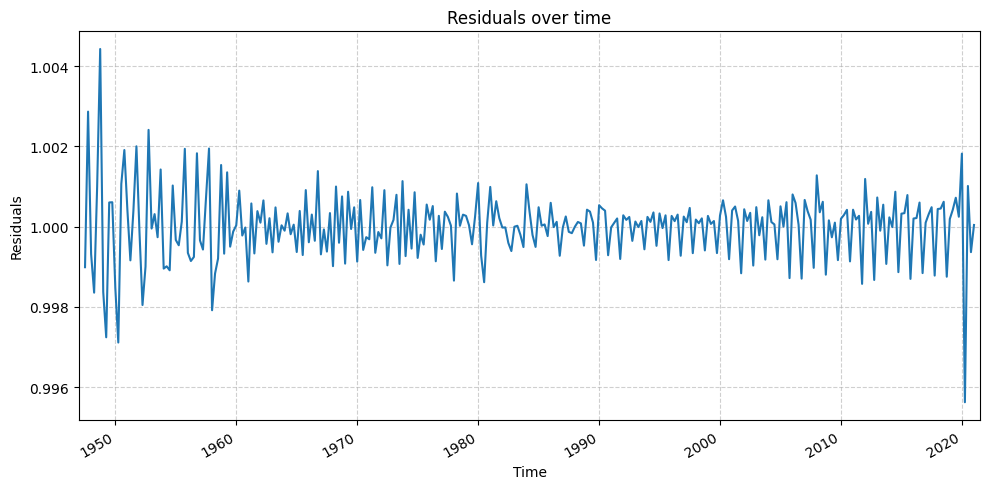

In [38]:
# Drop NaN values from the residuals of the decomposition
myresid = xdec.resid.dropna()  

# Plot Graph
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(myresid)
ax.set_xlabel('Time')
ax.set_ylabel('Residuals')
ax.set_title('Residuals over time')
ax.set_xlim(pd.to_datetime('1947-01-01'), pd.to_datetime('2021-07-01'))
ax.grid(True, linestyle='--', alpha=0.6)  

fig.autofmt_xdate()
plt.tight_layout() 

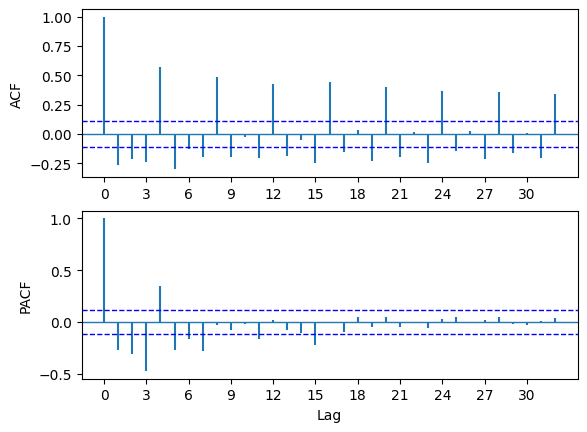

In [39]:
# Plot the ACF and PACF for the residuals of the decomposition
acf_pacf_fig(myresid,        # Residuals from decomposition
             both=True,      # Display both ACF and PACF plots
             lag=32)         # Number of lags to include in the plots

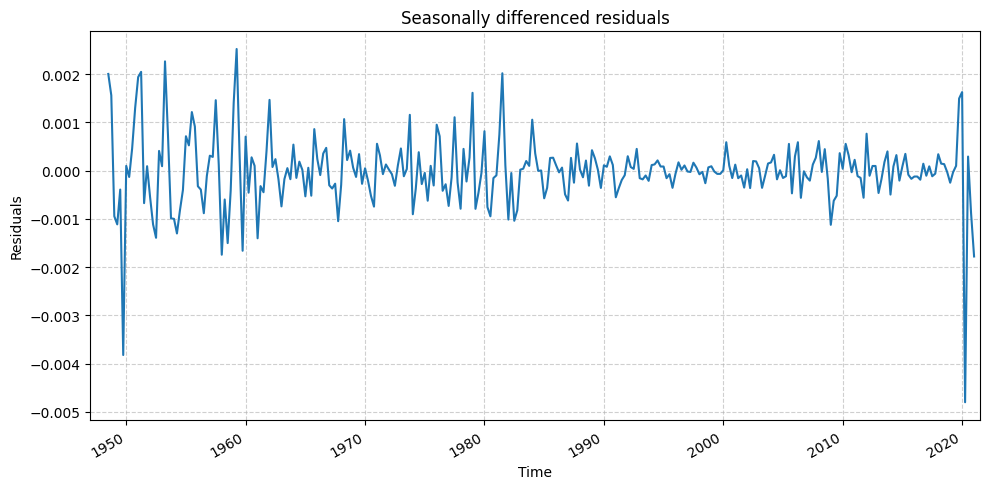

In [40]:
# Apply seasonal differencing to the residuals from decomposition
dmyresid = diff(myresid,                # Residuals from decomposition
                k_diff=0,               # No regular differencing
                k_seasonal_diff=1,      # Apply one seasonal differencing step
                seasonal_periods=4)     # Define the seasonal period as 4 (quarterly data)

# Plot the seasonally differenced residuals
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(dmyresid)
ax.set_xlabel('Time')
ax.set_ylabel('Residuals')
ax.set_title('Seasonally differenced residuals')
ax.set_xlim(pd.to_datetime('1947-01-01'), pd.to_datetime('2021-07-01'))
ax.grid(True, linestyle='--', alpha=0.6)  

fig.autofmt_xdate()
plt.tight_layout() 

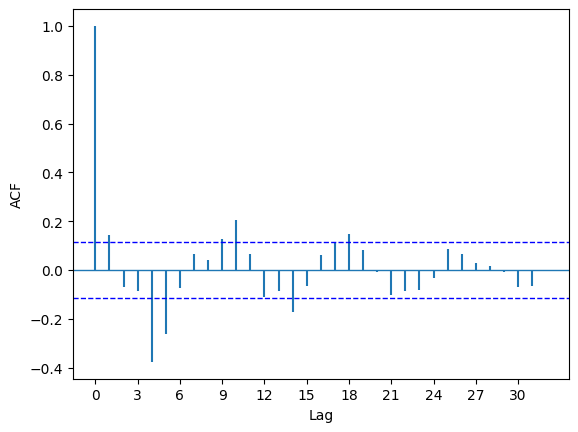

In [41]:
# Plot the ACF of the seasonally differenced residuals
acf_pacf_fig(dmyresid,   # Differenced residuals from decomposition
             both=False,  # Plot only ACF (not PACF)
             lag=32)      # Display up to 32 lags

In [42]:
# Perform the KPSS test on the seasonally differenced residuals
kpss_stat, p_value, lags, critical_values = kpss(dmyresid,  # Differenced residuals
                                                  regression='c',  # Test for stationarity around a constant
                                                  nlags='auto')    # Automatically determine lag selection

# Display the results
print(f"KPSS Statistic: {kpss_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Number of lags used: {lags}")

# Interpretation of results
if p_value < 0.05:
    print("p-value < 0.05: Reject H0 → The series is likely non-stationary.")
else:
    print("p-value > 0.05: Fail to Reject H0 → No evidence of non-stationarity.")

KPSS Statistic: 0.0618
p-value: 0.1000
Number of lags used: 5
p-value > 0.05: Fail to Reject H0 → No evidence of non-stationarity.


## A Typical Trend-Stationary Model and Difference-Stationary Model

In [44]:
# Create a time index as a Pandas Series with 300 values of type float64
t = pd.Series(range(300), dtype='float64')  

# Define a linear trend component: Tt = 0.1 + 0.4*t
Tt = 0.1 + 0.4 * t  

# Set a random seed for reproducibility
np.random.seed(13711)  

# Generate white noise with mean 0 and standard deviation 2
wn = np.random.normal(loc=0, scale=2, size=300)

In [45]:
# X follows a deterministic trend with random noise
X = Tt + wn  

# Stochastic trend
Y = RandomWalk_with_drift(drift=0.4, nsample=300, burnin=10)  

# Create a DataFrame to store both time series with descriptive column names
XY = pd.DataFrame({
    '$X_t = 0.1 + 0.4t + \epsilon_t$': X,    # Deterministic trend with noise
    '$Y_t = 0.4 + Y_{t-1} + \epsilon_t$': Y  # Stochastic trend (Random Walk with drift)
})

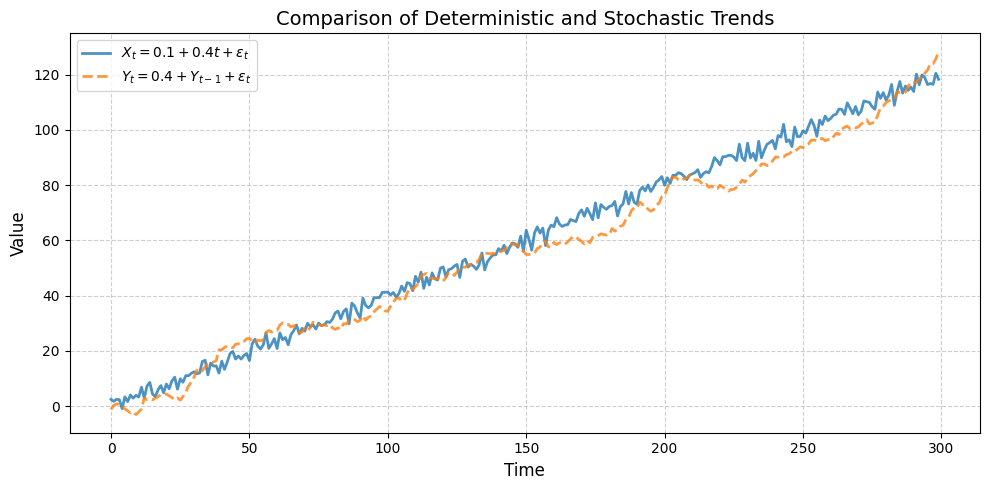

In [46]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot each series separately with specific styles
ax.plot(XY.iloc[:, 0], linestyle='-', linewidth=2, alpha=0.8, label=XY.columns[0])
ax.plot(XY.iloc[:, 1], linestyle='--', linewidth=2, alpha=0.8, label=XY.columns[1])

# Set axis labels and title
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('Comparison of Deterministic and Stochastic Trends', fontsize=14)

# Add grid for better visualization
ax.grid(True, linestyle='--', alpha=0.6)

# Add a legend
ax.legend(loc='upper left', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

## Unit Root Processes

Consider the **Autoregressive Process of Order 5 (AR(5))** is given by:

$$
X_t = -0.2 X_{t-1} + 0.0 X_{t-2} + 0.0 X_{t-3} + 0.6 X_{t-4} + 0.2 X_{t-5} + \varepsilon_t
$$

The **characteristic polynomial** corresponding to this AR(5) process is:

$$
1 + 0.2B - 0.6B^4 - 0.2B^5 = 0
$$

In [49]:
# Define the AR characteristic polynomial coefficients
p = [-0.2, 0.0, 0.0, -0.6, -0.2, 1] 

# Compute the roots of the polynomial
roots = np.roots(p)  

# Compute the absolute values of the roots
abs(roots)  

# Define the AR process coefficients (rearranged with leading 1 for AR process)
ar = np.array([1, -0.2, -0.6, 0.0, 0.0, -0.2])  

# Set random seed for reproducibility
np.random.seed(12347)  

# Generate a sample from the ARMA process (AR with MA = [1] for pure AR)
x = arma_generate_sample(ar=ar, ma=[1], nsample=500)  

# Convert the generated series to a pandas Series
x = pd.Series(x)  

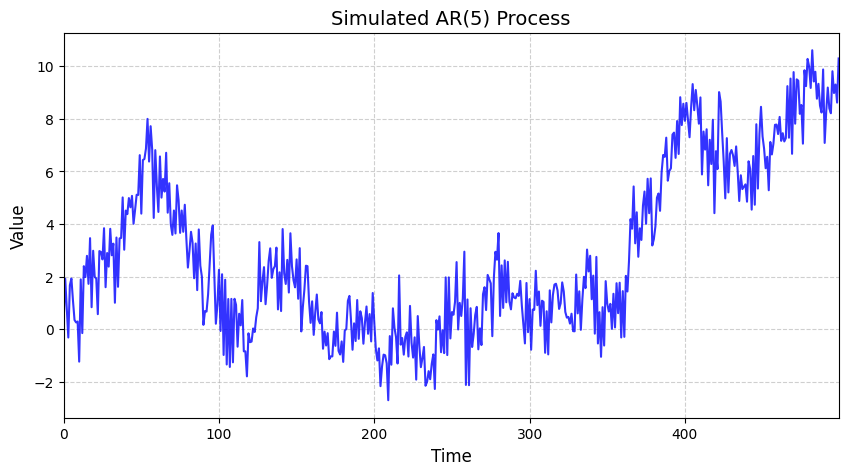

In [50]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the generated AR(5) process
ax.plot(x, linestyle='-', marker='', color='b', alpha=0.8)

# Add title and labels
ax.set_title('Simulated AR(5) Process', fontsize=14)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_xlim(0, 499)

# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

## Unit Root Tests

In [52]:
url7 = ('https://raw.githubusercontent.com/QuantLet/pyTSA/refs/heads/main/pyTSA_UnitRootTest/us-q-rgdp.csv')

usrgdp = pd.read_csv(url7, header = 0)

usrgdp

,DATE,GDPC1
0,1947-01-01,2034.450
1,1947-04-01,2029.024
2,1947-07-01,2024.834
3,1947-10-01,2056.508
4,1948-01-01,2087.442
...,...,...
293,2020-04-01,17258.205
294,2020-07-01,18560.774
295,2020-10-01,18767.778
296,2021-01-01,19055.655


In [53]:
# Convert the 'DATE' column to datetime format
usrgdp['DATE'] = pd.to_datetime(usrgdp['DATE'])

# Set 'DATE' as the index
usrgdp.set_index('DATE', inplace=True)

# Converting Pandas into a Series
# usrgdp = usrgdp['GDPC1']

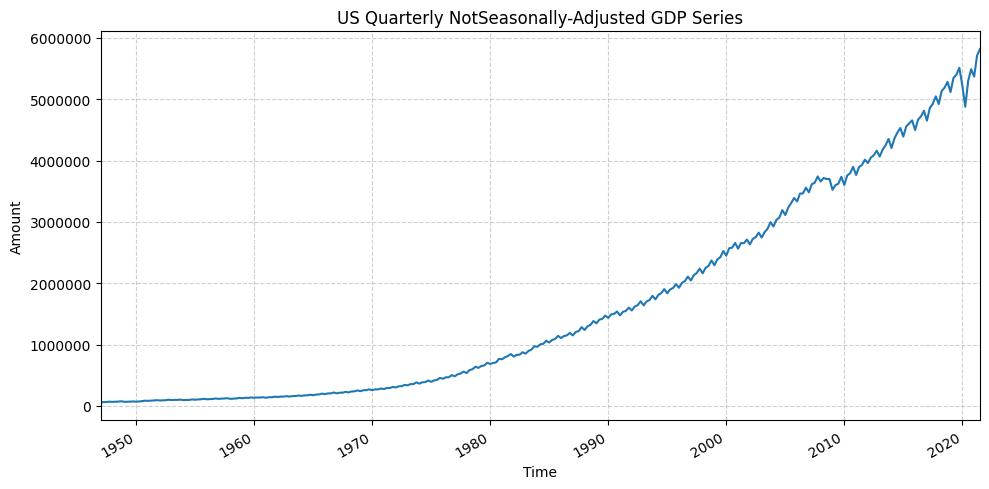

In [54]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(usgdp)
ax.set_xlabel('Time')
ax.set_ylabel('Amount')
ax.set_title('US Quarterly NotSeasonally-Adjusted GDP Series')
ax.set_xlim(pd.to_datetime('1947-01-01'), pd.to_datetime('2021-07-01'))
ax.grid(True, linestyle='--', alpha=0.6) 

# Remove scientific notation on y-axis
ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='y') 

fig.autofmt_xdate()
plt.tight_layout()

In [55]:
# Take the natural logarithm of real GDP
lusrgdp = np.log(usrgdp['GDPC1'])  

# Rename the series for clarity
lusrgdp.name = 'lrgdp'  

lusrgdp

DATE
1947-01-01    7.617981
1947-04-01    7.615310
1947-07-01    7.613243
1947-10-01    7.628765
1948-01-01    7.643695
                ...   
2020-04-01    9.756043
2020-07-01    9.828806
2020-10-01    9.839897
2021-01-01    9.855119
2021-04-01    9.871394
Name: lrgdp, Length: 298, dtype: float64

In [56]:
# Perform the Augmented Dickey-Fuller (ADF) test on the log-transformed real GDP series
adf_result = adfuller(lusrgdp, regression='ct')  # 'ct' includes a constant and trend

# Print the results in a readable format
print("\n=== Augmented Dickey-Fuller Test ===")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.6f}")
print(f"Critical Values: {adf_result[4]}")
print(f"Number of Lags Used: {adf_result[2]}")
print(f"Number of Observations Used: {adf_result[3]}")

# Interpretation of results
if adf_result[1] < 0.05:
    print("\nConclusion: The series is stationary (reject H0).")
else:
    print("\nConclusion: The series is non-stationary (fail to reject H0).")


=== Augmented Dickey-Fuller Test ===
ADF Statistic: -0.8094
p-value: 0.964881
Critical Values: {'1%': -3.9895792190177497, '5%': -3.4253766620686186, '10%': -3.135801074760346}
Number of Lags Used: 0
Number of Observations Used: 297

Conclusion: The series is non-stationary (fail to reject H0).


In [57]:
# Perform the KPSS test on the log-transformed real GDP series
kpss_result = kpss(lusrgdp, regression='ct', nlags='auto')  # 'ct' includes a constant and trend

# Print the results in a readable format
print("\n=== KPSS Test ===")
print(f"KPSS Statistic: {kpss_result[0]:.4f}")
print(f"p-value: {kpss_result[1]:.6f}")
print(f"Critical Values: {kpss_result[3]}")
print(f"Number of Lags Used: {kpss_result[2]}")

# Interpretation of results
if kpss_result[1] < 0.05:
    print("\nConclusion: The series is non-stationary (reject H0).")
else:
    print("\nConclusion: The series is stationary (fail to reject H0).")


=== KPSS Test ===
KPSS Statistic: 0.5538
p-value: 0.010000
Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Number of Lags Used: 10

Conclusion: The series is non-stationary (reject H0).


In [58]:
# Create a time trend variable for the log real GDP series
t = pd.Series(range(len(lusrgdp)), dtype='float64')  # Generate a sequence from 0 to the length of the series
t.index = lusrgdp.index                              # Set the same index as the original series
t.name = 'trend'                                     # Name the variable as 'trend'

# Add a constant term to the trend variable
ct = sm.add_constant(t, prepend=False)  # Adds an intercept term (constant) to the regression model

# Fit an OLS regression model: log real GDP as the dependent variable and trend + constant as regressors
modfit = sm.OLS(lusrgdp, ct).fit()

# Print the model summary with coefficients, R-squared, p-values, etc.
print(modfit.summary())  

                            OLS Regression Results                            
Dep. Variable:                  lrgdp   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 2.467e+04
Date:                Tue, 11 Mar 2025   Prob (F-statistic):          4.07e-287
Time:                        15:29:00   Log-Likelihood:                 356.15
No. Observations:                 298   AIC:                            -708.3
Df Residuals:                     296   BIC:                            -700.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
trend          0.0078   4.95e-05    157.070      0.0

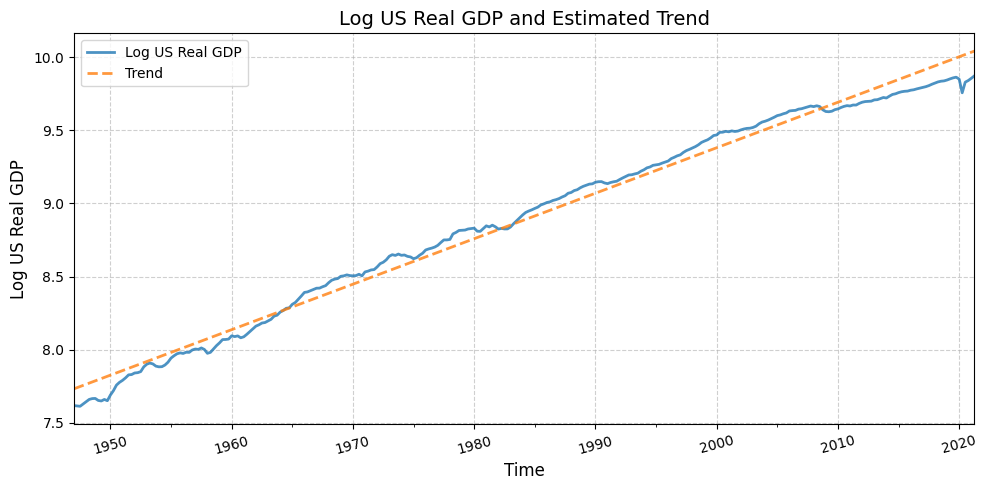

In [59]:
# Extract the fitted trend values from the model
myfitted = modfit.fittedvalues  

# Create a DataFrame to compare the log US real GDP with its estimated trend
dnf = pd.DataFrame({'Log US Real GDP': lusrgdp,   # Log-transformed US real GDP
                    'Trend': myfitted})           # Fitted trend from the regression model

# Plot both the log GDP and its trend
fig, ax = plt.subplots(figsize=(10, 5))  # Set figure size
dnf.plot(ax=ax, style=['-', '--'], linewidth=2, alpha=0.8)  # Solid line for GDP, dashed line for trend

# Customize plot labels and title
ax.set_xlabel('Time', fontsize=12)                                # Label for x-axis
ax.set_ylabel('Log US Real GDP', fontsize=12)                     # Label for y-axis
ax.set_title('Log US Real GDP and Estimated Trend', fontsize=14)  # Title of the plot

# Rotate x-axis ticks for better readability
plt.xticks(rotation=15)

# Add grid for better visualization
ax.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()

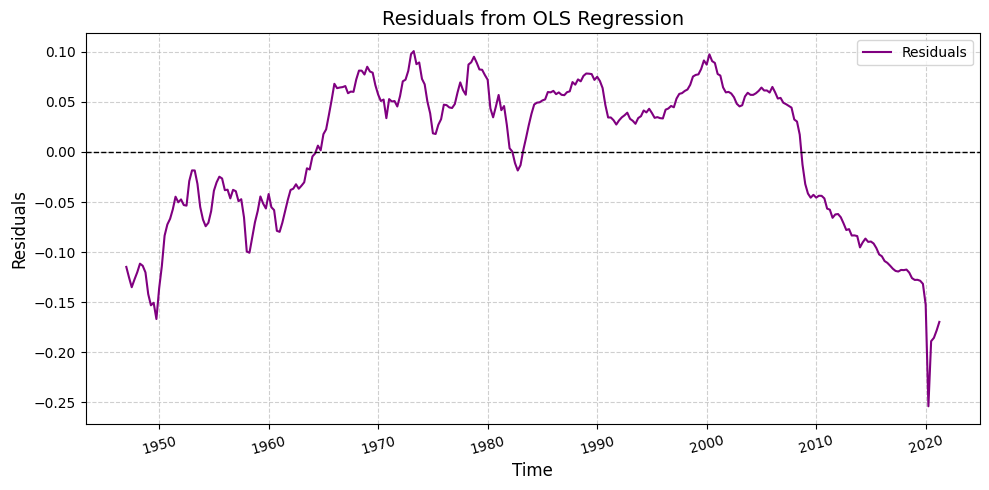

In [60]:
# Extract residuals from the model
myresid = modfit.resid  # Model residuals (difference between observed and fitted values)

# Plot graph
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(myresid, linestyle='-', color='purple', linewidth=1.5, label="Residuals")
ax.axhline(y=0, color='black', linestyle='--', linewidth=1) 
ax.set_xlabel('Time', fontsize=12)   
ax.set_ylabel('Residuals', fontsize=12)  
ax.set_title('Residuals from OLS Regression', fontsize=14)  
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(loc='best')  
plt.xticks(rotation=15)  

plt.tight_layout() 
plt.show()

In [61]:
# Perform the Augmented Dickey-Fuller (ADF) test to check for stationarity
adf_result = adfuller(myresid, regression='c')  # 'c' means we include a constant in the test

# Extract relevant results from the ADF test
adf_stat = adf_result[0]   # Test statistic
p_value = adf_result[1]    # p-value to assess significance
lags_used = adf_result[2]  # Number of lags used in the test
n_obs = adf_result[3]      # Number of observations used in the regression

# Critical values at different significance levels (1%, 5%, 10%)
crit_values = adf_result[4]  

# Print the results
print("\n=== Augmented Dickey-Fuller Test Results ===")
print(f"ADF Test Statistic: {adf_stat:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"Number of Lags Used: {lags_used}")
print(f"Number of Observations Used: {n_obs}")
print("\nCritical Values:")
for key, value in crit_values.items():
    print(f"  {key}: {value:.4f}")

# Interpretation of the results
if p_value < 0.05:
    print("\nConclusion: H0 is rejected → The series is stationary.")
else:
    print("\nConclusion: Fail to reject H0 → The series is NOT stationary.")


=== Augmented Dickey-Fuller Test Results ===
ADF Test Statistic: -1.5244
p-value: 0.521412
Number of Lags Used: 2
Number of Observations Used: 295

Critical Values:
  1%: -3.4527
  5%: -2.8714
  10%: -2.5720

Conclusion: Fail to reject H0 → The series is NOT stationary.


In [62]:
# Perform the KPSS test to check for stationarity
kpss_result = kpss(myresid, regression='c', nlags='auto')  # 'c' includes a constant (level-stationarity)

# Extract relevant results from the KPSS test
kpss_stat = kpss_result[0]    # Test statistic
p_value = kpss_result[1]      # p-value for the test
lags_used = kpss_result[2]    # Number of lags used in the test

# Critical values at different significance levels (1%, 5%, 10%)
crit_values = kpss_result[3]  

# Print the results
print("\n=== KPSS Test Results ===")
print(f"KPSS Test Statistic: {kpss_stat:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"Number of Lags Used: {lags_used}")
print("\nCritical Values:")
for key, value in crit_values.items():
    print(f"  {key}: {value:.4f}")

# Interpretation of the results
if p_value < 0.05:
    print("\nConclusion: H0 is rejected → The series is NOT stationary.")
else:
    print("\nConclusion: Fail to reject H0 → The series is stationary at level.")


=== KPSS Test Results ===
KPSS Test Statistic: 0.5538
p-value: 0.029555
Number of Lags Used: 10

Critical Values:
  10%: 0.3470
  5%: 0.4630
  2.5%: 0.5740
  1%: 0.7390

Conclusion: H0 is rejected → The series is NOT stationary.


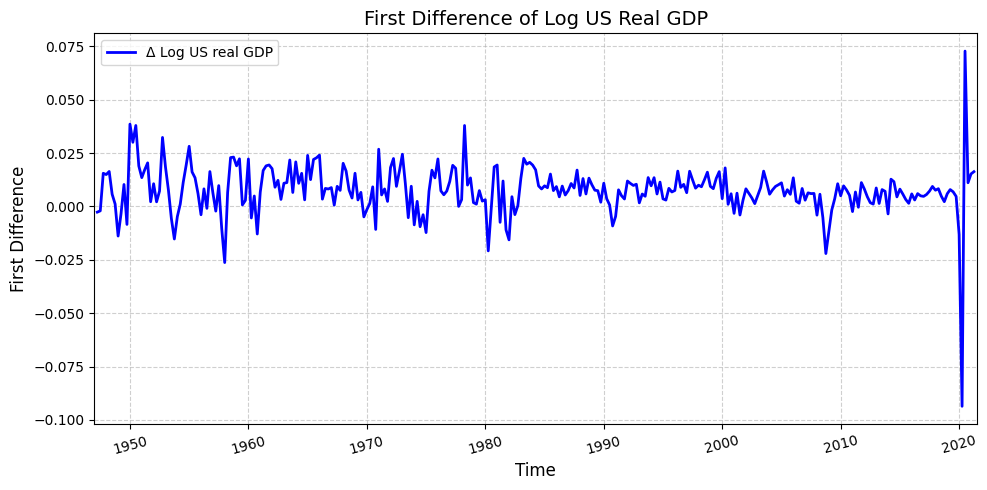

In [63]:
# Compute the first difference of the log of US real GDP
dlusrgdp = lusrgdp.diff().dropna() 

# Plot Graph
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(dlusrgdp, linestyle='-', color='b', linewidth=2, label="Δ Log US real GDP")
ax.set_xlabel('Time', fontsize=12)  
ax.set_ylabel('First Difference', fontsize=12) 
ax.set_title('First Difference of Log US Real GDP', fontsize=14)  
ax.grid(True, linestyle='--', alpha=0.6)  
ax.legend(loc='best')
ax.set_xlim(pd.to_datetime('1947-01-01'), pd.to_datetime('2021-07-01'))
plt.xticks(rotation=15) 

plt.tight_layout()  
plt.show()

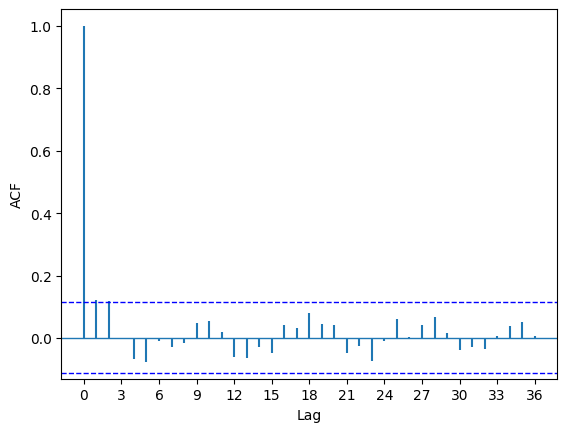

In [64]:
# Plot the ACF (Autocorrelation Function) for the differenced log US real GDP
acf_pacf_fig(dlusrgdp,    # Input time series (differenced log US real GDP)
             both=False,  # Display only the ACF (not the PACF)
             lag=36)      # Number of lags to consider for autocorrelation analysis

In [65]:
# Perform the Augmented Dickey-Fuller (ADF) test to check for stationarity
adf_result = adfuller(dlusrgdp, regression='c')  # 'c' means we include a constant in the test

# Extract relevant results from the ADF test
adf_stat = adf_result[0]   # Test statistic
p_value = adf_result[1]    # p-value to assess significance
lags_used = adf_result[2]  # Number of lags used in the test
n_obs = adf_result[3]      # Number of observations used in the regression

# Critical values at different significance levels (1%, 5%, 10%)
crit_values = adf_result[4]  

# Print the results
print("\n=== Augmented Dickey-Fuller Test Results ===")
print(f"ADF Test Statistic: {adf_stat:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"Number of Lags Used: {lags_used}")
print(f"Number of Observations Used: {n_obs}")
print("\nCritical Values:")
for key, value in crit_values.items():
    print(f"  {key}: {value:.4f}")

# Interpretation of the results
if p_value < 0.05:
    print("\nConclusion: H0 is rejected → The series is stationary.")
else:
    print("\nConclusion: Fail to reject H0 → The series is NOT stationary.")


=== Augmented Dickey-Fuller Test Results ===
ADF Test Statistic: -10.1855
p-value: 0.000000
Number of Lags Used: 1
Number of Observations Used: 295

Critical Values:
  1%: -3.4527
  5%: -2.8714
  10%: -2.5720

Conclusion: H0 is rejected → The series is stationary.


In [66]:
# Perform the KPSS test to check for stationarity
kpss_result = kpss(dlusrgdp, regression='c', nlags='auto')  # 'c' includes a constant (level-stationarity)

# Extract relevant results from the KPSS test
kpss_stat = kpss_result[0]    # Test statistic
p_value = kpss_result[1]      # p-value for the test
lags_used = kpss_result[2]    # Number of lags used in the test

# Critical values at different significance levels (1%, 5%, 10%)
crit_values = kpss_result[3]  

# Print the results
print("\n=== KPSS Test Results ===")
print(f"KPSS Test Statistic: {kpss_stat:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"Number of Lags Used: {lags_used}")
print("\nCritical Values:")
for key, value in crit_values.items():
    print(f"  {key}: {value:.4f}")

# Interpretation of the results
if p_value < 0.05:
    print("\nConclusion: H0 is rejected → The series is NOT stationary.")
else:
    print("\nConclusion: Fail to reject H0 → The series is stationary at level.")


=== KPSS Test Results ===
KPSS Test Statistic: 0.4930
p-value: 0.043242
Number of Lags Used: 4

Critical Values:
  10%: 0.3470
  5%: 0.4630
  2.5%: 0.5740
  1%: 0.7390

Conclusion: H0 is rejected → The series is NOT stationary.


Unfortunately, the KPSS test for stationarity of the differenced series fails since the
p-value is 0.0432 at this point. Of course, it is well known that all statistical tests
occasionally make mistakes.

## Spurious Regression

In [69]:
# Define the autoregressive (AR) coefficient array for an AR(1) process
ar = np.array([1, -1.0])  # AR(1) model with coefficient -1.0

# Set a random seed for reproducibility
np.random.seed(1373)

# Generate two independent ARMA(1,0) samples with no moving average component
x = arma_generate_sample(ar=ar, ma=[1], nsample=300)  # First sample
y = arma_generate_sample(ar=ar, ma=[1], nsample=300)  # Second sample

# Convert generated samples into pandas Series
x = pd.Series(x)  
y = pd.Series(y)

# Create a DataFrame combining both series
xy = pd.DataFrame({'x': x, 'y': y})                   # Store both series in a DataFrame for analysis

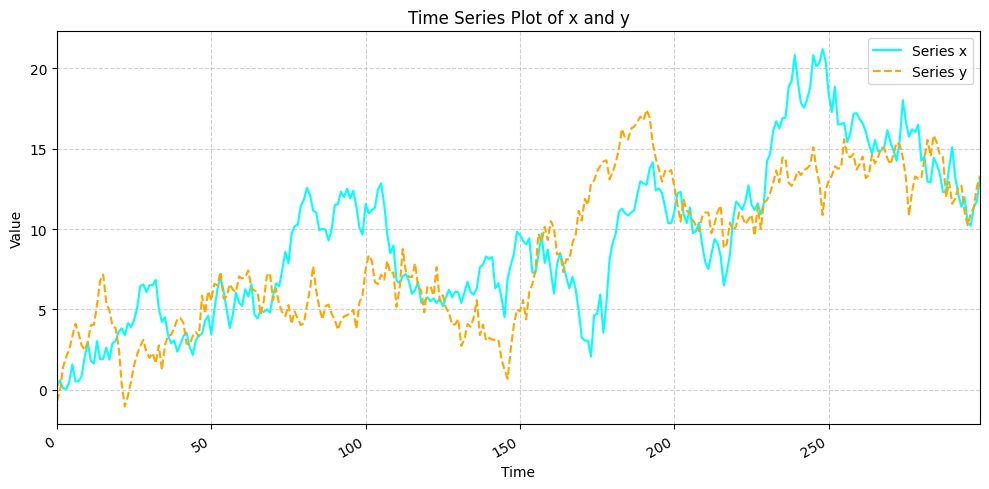

In [70]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(xy.index, xy['x'], linestyle='-', marker='', color='cyan', label='Series x')     # Plot series x
ax.plot(xy.index, xy['y'], linestyle='--', marker='', color='orange', label='Series y')  # Plot series y
ax.set_xlabel('Time')  
ax.set_ylabel('Value') 
ax.set_title('Time Series Plot of x and y') 
ax.set_xlim(0,299)

ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [71]:
# Perform Ordinary Least Squares (OLS) regression
regresults = smf.ols('y ~ x', data=xy).fit()  # Fit a linear regression model with 'y' as the dependent variable and 'x' as the independent variable

# Print the regression summary
print(regresults.summary())                   # Display the regression results, including coefficients, standard errors, t-values, and p-values

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     300.7
Date:                Tue, 11 Mar 2025   Prob (F-statistic):           4.60e-47
Time:                        15:29:02   Log-Likelihood:                -772.86
No. Observations:                 300   AIC:                             1550.
Df Residuals:                     298   BIC:                             1557.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3623      0.400      5.900      0.0

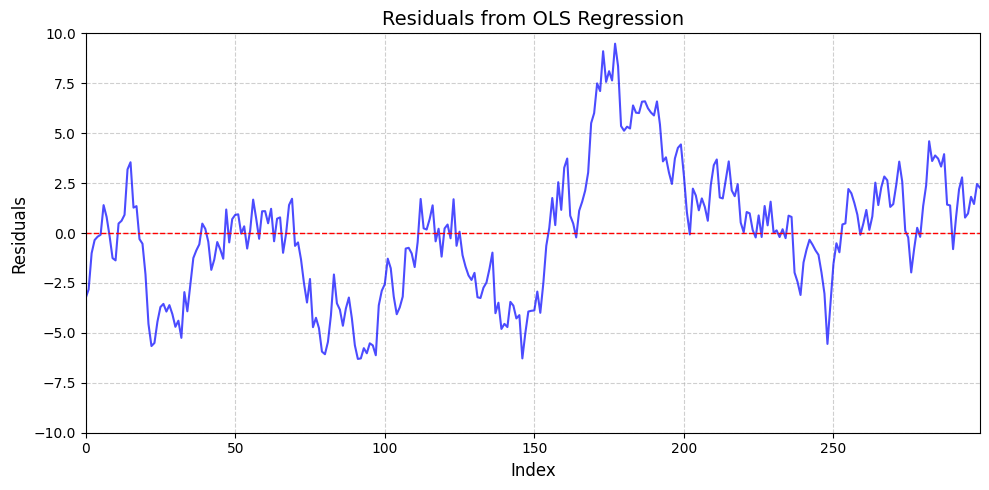

In [72]:
# Extract residuals from the regression model
resid = regresults.resid    # Residuals represent the differences between observed and predicted values

# Plot the residuals
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(resid, linestyle='-', marker='', markersize=3, color='b', alpha=0.7)  
ax.axhline(y=0, color='r', linestyle='--', linewidth=1)

ax.set_xlabel('Index', fontsize=12) 
ax.set_ylabel('Residuals', fontsize=12)  
ax.set_title('Residuals from OLS Regression', fontsize=14)
ax.set_xlim(0,299)
ax.set_ylim(-10,10)
ax.grid(True, linestyle='--', alpha=0.6)  
plt.tight_layout()  
plt.show()

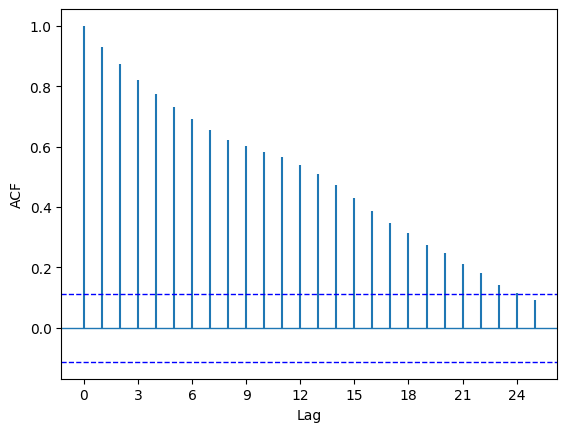

In [73]:
# Plot the ACF of the residuals to check for autocorrelation
acf_pacf_fig(resid,       # Residual series from the OLS regression
             both=False,  # Only plot the ACF (not PACF)
             lag=25)      # Display up to 25 lags

In [74]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(resid, regression = 'ctt')  # Include a constant, trend, and quadratic trend in the test

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -3.4723958089286557
p-value: 0.12005775701122529

p-value > alpha; H0: Not Stationary


In [75]:
# Compute the first-order difference of 'xy' to remove trends
dxy = xy.diff(1).dropna()     # Take first differences and drop NaN values
dxy.columns = ['dx', 'dy']    # Rename columns for clarity

# Fit an OLS regression model on the differenced data
dregresults = smf.ols('dy ~ dx', data=dxy).fit()  # Regress 'dy' on 'dx'

# Print the regression summary
print(dregresults.summary())  # Display statistical results of the regression

                            OLS Regression Results                            
Dep. Variable:                     dy   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                  0.009652
Date:                Tue, 11 Mar 2025   Prob (F-statistic):              0.922
Time:                        15:29:03   Log-Likelihood:                -409.56
No. Observations:                 299   AIC:                             823.1
Df Residuals:                     297   BIC:                             830.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0473      0.055      0.855      0.3

## Cointegration of Prices of WTI Crude Oil and Brent Crude Oil

In [77]:
url14 = ('https://raw.githubusercontent.com/QuantLet/pyTSA/refs/heads/main/pyTSA_CointegrationOil/WTI-Brent.csv')

bwoil = pd.read_csv(url14)

bwoil

,Brent,WTI
0,18.58,19.44
1,18.86,20.07
2,19.86,21.34
3,18.98,20.31
4,18.31,19.53
...,...,...
394,32.01,29.21
395,18.38,16.55
396,29.38,28.56
397,40.27,38.31


In [78]:
# Create a date range starting from May 1987, with a monthly frequency
dates = pd.date_range('1987-05', periods=len(bwoil), freq='M')  

# Assign the generated date range as the index of the 'bwoil' DataFrame
bwoil.index = dates  

bwoil

,Brent,WTI
1987-05-31,18.58,19.44
1987-06-30,18.86,20.07
1987-07-31,19.86,21.34
1987-08-31,18.98,20.31
1987-09-30,18.31,19.53
...,...,...
2020-03-31,32.01,29.21
2020-04-30,18.38,16.55
2020-05-31,29.38,28.56
2020-06-30,40.27,38.31


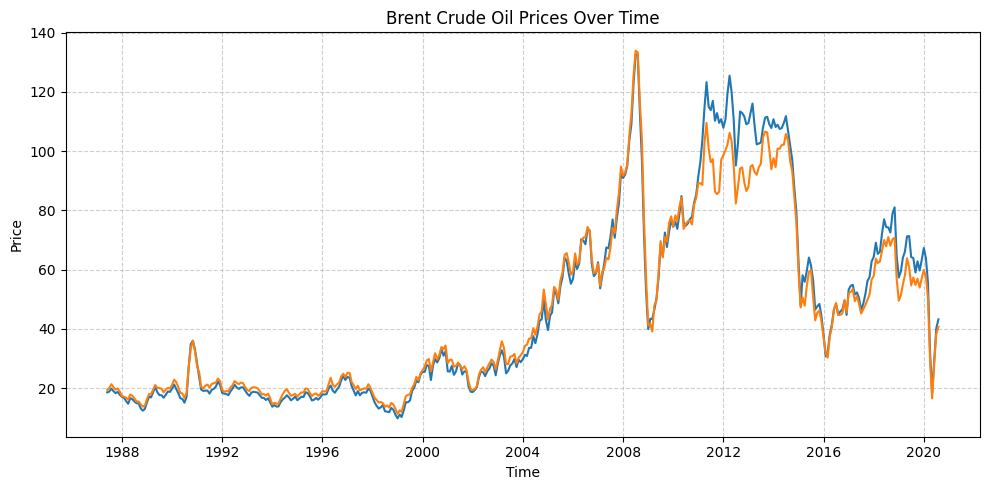

In [79]:
# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(bwoil)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Brent Crude Oil Prices Over Time')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

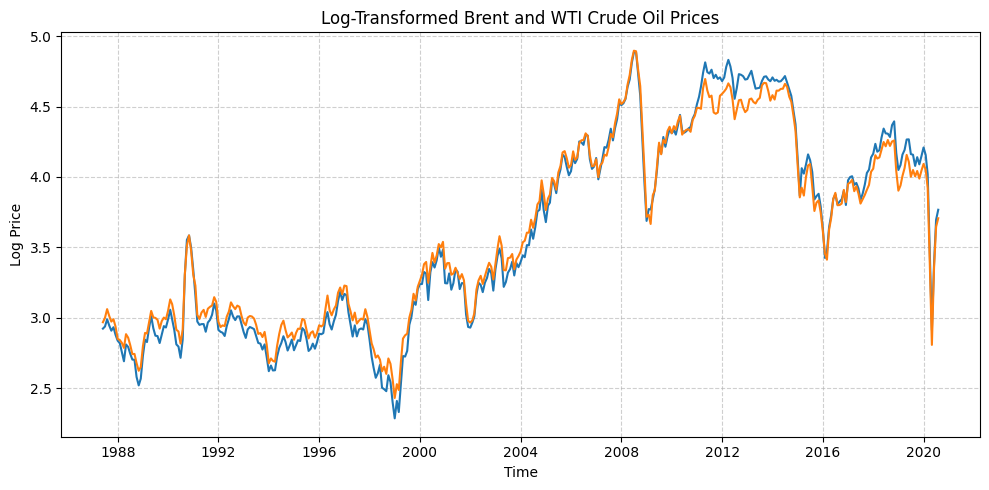

In [80]:
# Take the natural logarithm of 'bwoil' dataset
logbw = np.log(bwoil)  

# Rename the columns for better labeling
logbw.columns = ['Log Brent Crude Oil Price', 'Log WTI Crude Oil Price']  

# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(logbw)
plt.xlabel('Time')
plt.ylabel('Log Price')
plt.title('Log-Transformed Brent and WTI Crude Oil Prices')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

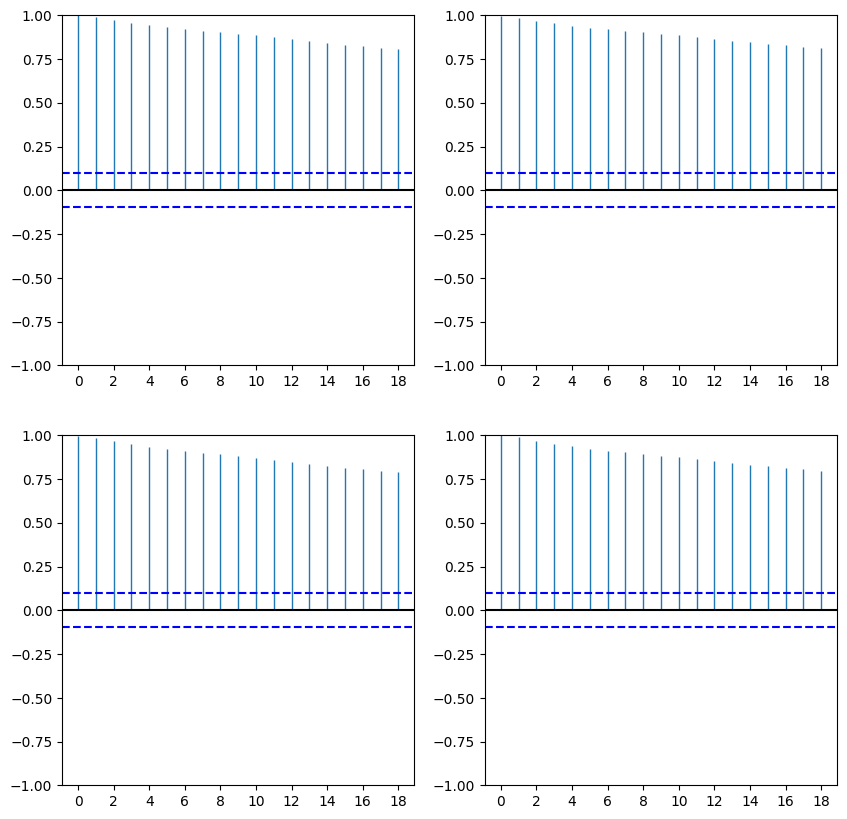

In [81]:
# Plot the autocorrelation function (ACF) for the log-transformed Brent and WTI crude oil prices  
multi_ACFfig(logbw,        # Data: Log-transformed Brent and WTI crude oil prices  
             nlags=18);    # Number of lags to display in the ACF plot (up to lag 18)  

In [82]:
# Rename the columns of the log-transformed oil price DataFrame  
logbw.columns = ['LBrent', 'LWTI']

logbw.head()

,LBrent,LWTI
1987-05-31,2.922086,2.967333
1987-06-30,2.937043,2.999226
1987-07-31,2.988708,3.060583
1987-08-31,2.943386,3.011113
1987-09-30,2.907447,2.971952


In [83]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(logbw['LWTI'], regression = 'c')  # 'c' includes a constant term 

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -1.6669594264260321
p-value: 0.44821129720261554

p-value > alpha; H0: Not Stationary


In [84]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(logbw['LBrent'], regression = 'c')  # 'c' includes a constant term 

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -1.577788675177648
p-value: 0.4947406374093962

p-value > alpha; H0: Not Stationary


In [85]:
# Take the first difference and remove NaN values    
dlogbw = logbw.diff(1).dropna()  

# Rename the columns to indicate the differenced series  
dlogbw.columns = ['DLBrent', 'DLWTI'] 

# Display the first few rows
dlogbw.head()  

,DLBrent,DLWTI
1987-06-30,0.014958,0.031893
1987-07-31,0.051664,0.061357
1987-08-31,-0.045322,-0.049470
1987-09-30,-0.035938,-0.039162
1987-10-31,0.024280,0.016756


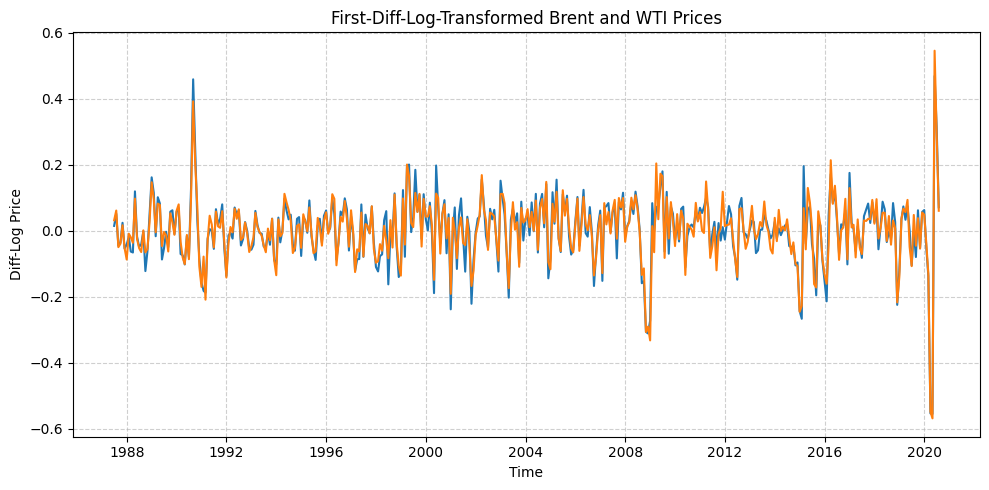

In [86]:
# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(dlogbw)
plt.xlabel('Time')
plt.ylabel('Diff-Log Price')
plt.title('First-Diff-Log-Transformed Brent and WTI Prices')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

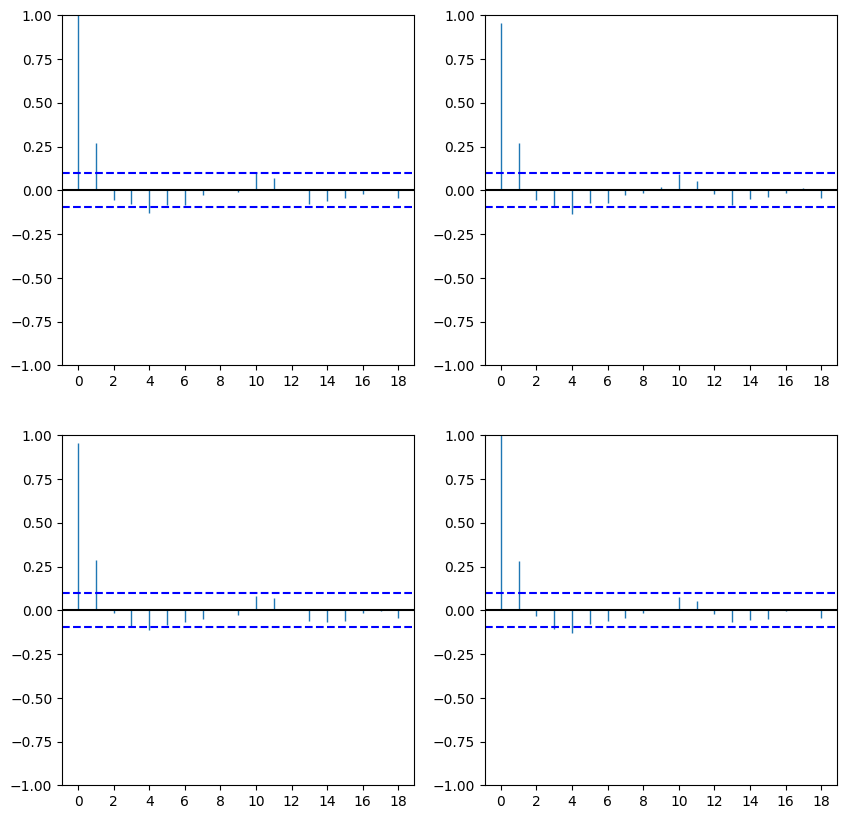

In [87]:
# Plot the ACF for the differenced log oil price series  
multi_ACFfig(dlogbw, nlags=18);

In [88]:
# Perform the Engle-Granger cointegration test between 'LWTI' and 'LBrent'
coint_test = coint(logbw.LWTI, logbw.LBrent, trend='c')  

# Extract test statistic, p-value, and critical values
test_statistic, p_value, critical_values = coint_test  

# Print results
print(f"Cointegration Test Statistic: {test_statistic:.3f}")
print(f"P-value: {p_value:.6f}")
print(f"Critical Values: {critical_values}")

# Interpretation of results
if p_value < 0.05:
    print("\nConclusion: Reject the null hypothesis (No cointegration).")
    print("LWTI and LBrent are cointegrated, meaning they share a long-term equilibrium relationship.")
    print("This suggests that, despite short-term deviations, their prices tend to move together over time.")
else:
    print("\nConclusion: Fail to reject the null hypothesis (No cointegration).")
    print("There is no strong evidence of a long-term equilibrium relationship between LWTI and LBrent.")

Cointegration Test Statistic: -5.621
P-value: 0.000010
Critical Values: [-3.92416899 -3.35152508 -3.05512345]

Conclusion: Reject the null hypothesis (No cointegration).
LWTI and LBrent are cointegrated, meaning they share a long-term equilibrium relationship.
This suggests that, despite short-term deviations, their prices tend to move together over time.


In [89]:
# Select the optimal lag order for the VAR model
selord = select_order(data=logbw,         # Input dataset (logarithm of Brent and WTI prices)
                      maxlags=10,         # Maximum number of lags to consider
                      deterministic='co') # Include constant and trend

# Display the selected optimal lag orders based on different criteria
selord.selected_orders

{'aic': 2, 'bic': 1, 'hqic': 2, 'fpe': 2}

In [90]:
# Select the cointegration rank using Johansen's trace and max eigenvalue tests
scr = select_coint_rank(logbw,         # Input dataset (logarithm of Brent and WTI prices)
                        det_order=0,   # No deterministic trend component
                        k_ar_diff=2)   # Number of lags used in the underlying VAR model

# Print a summary of the cointegration rank selection results
print(scr.summary())

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          28.20          15.49
  1   2          3.031          3.841
-------------------------------------


### Interpreting the Results

#### First row $ (r_0 = 0 \text{ vs. } r_1 = 2) $
- **Null Hypothesis $ (H_0) $**: No cointegration (i.e., no long-run equilibrium relationship between the series).
- **Test Statistic**: $ 28.20 $
- **Critical Value**: $ 15.49 $
- **Decision**: Since $ 28.20 > 15.49 $, we reject $ H_0 $, meaning at least one cointegration relationship exists.

#### Second row $ (r_0 = 1 \text{ vs. } r_1 = 2) $
- **Null Hypothesis $ (H_0) $**: At most **one** cointegration relationship.
- **Test Statistic**: $ 3.031 $
- **Critical Value**: $ 3.841 $
- **Decision**: Since $ 3.031 < 3.841 $, we fail to reject $ H_0 $, meaning **there is exactly one cointegration relationship**.

### Conclusion
The results suggest that there is **one cointegration relationship** between the two time series (e.g., Brent and WTI oil prices). This implies that these two price series move together in the long run, even though they may fluctuate in the short term.


In [92]:
# Displays the number of cointegrating relationships detected
scr.rank

1

In [93]:
# Define a Vector Error Correction Model (VECM) with:
vecmod = VECM(endog=logbw,         # The log-transformed Brent and WTI oil price data
              k_ar_diff=2,         # Number of lags in the short-run dynamics (equivalent to VAR(2))
              coint_rank=1,        # Cointegration rank (one cointegrating relationship)
              deterministic='co')  # Include constant and trend in the model

# Fit the VECM model to estimate parameters
vecmfit = vecmod.fit()

# Print the summary of the fitted model
print(vecmfit.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation LBrent
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.037      0.148      0.882      -0.066       0.077
L1.LBrent      0.1513      0.166      0.911      0.362      -0.174       0.477
L1.LWTI        0.1751      0.174      1.005      0.315      -0.166       0.517
L2.LBrent     -0.0630      0.165     -0.382      0.702      -0.386       0.260
L2.LWTI       -0.0899      0.173     -0.521      0.603      -0.428       0.248
Det. terms outside the coint. relation & lagged endog. parameters for equation LWTI
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0577      0.035      1.649      0.099      -0.011       0.126
L1.LBrent      0.1568      0.159      0.

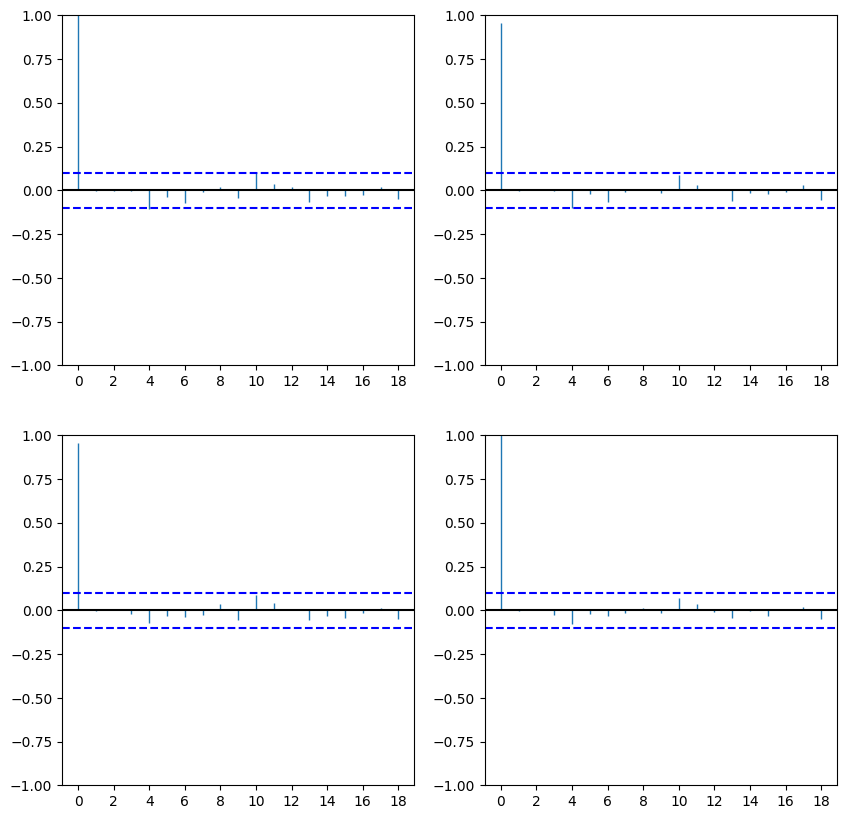

In [94]:
# Extract residuals from the fitted VECM model
vecmresid = vecmfit.resid  

# Plot the autocorrelation function (ACF) for the residuals
multi_ACFfig(vecmresid, nlags=18);

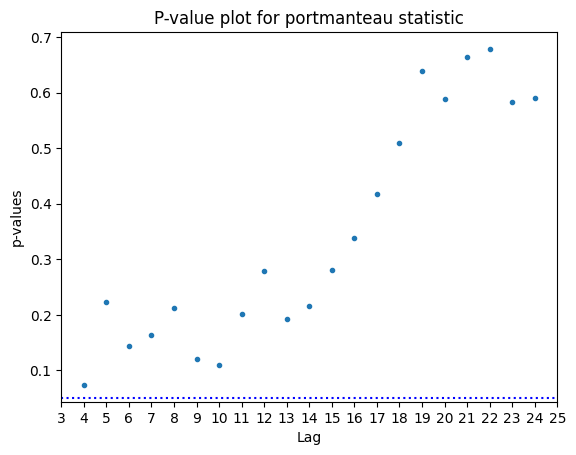

In [95]:
# Perform the Ljung-Box test on the residuals of the VECM model
q, p = MultiQpvalue_plot(vecmresid,           # Residuals from the VECM model
                         p=3,                 # Number of autoregressive lags
                         q=0,                 # Number of moving average lags
                         noestimatedcoef=10,  # Number of estimated coefficients
                         nolags=24)           # Number of lags to test autocorrelation up to 24

## Real Case of Spurious Regression and Noncointegration

    rgnp: The US real gross national product (GNP) measured in billions of chained 2005 dollars and seasonally adjusted
    
    tb3m: Rate of US 3-month treasury bills obtained by simple average of the monthly rates within a quarter
    
    gs10: Rate of US 10-year constant maturity interest rate obtained by the same method as that of tb3m
    
    m1sk: The US M1 money stock obtained from the average of monthly data, which are measured in billions of dollars and seasonally adjusted

In [98]:
url15 = ('https://raw.githubusercontent.com/QuantLet/pyTSA/refs/heads/main/pyTSA_MacroUSCointegration/USmacronInRate.txt')
usm = pd.read_table(url15, sep = '\s+', header = 0)
usm 

,year,mon,day,rgnp,tb3m,gs10,m1sk
0,1959,1,1,2725.1,2.773333,3.990000,139.3333
1,1959,4,1,2793.6,3.000000,4.256667,140.5333
2,1959,7,1,2791.5,3.540000,4.503333,141.5333
3,1959,10,1,2802.2,4.230000,4.583333,140.3000
4,1960,1,1,2864.0,3.873333,4.486667,139.9000
...,...,...,...,...,...,...,...
209,2011,4,1,13486.1,0.046667,3.210000,1926.7670
210,2011,7,1,13534.7,0.023333,2.426667,2077.8000
211,2011,10,1,13672.9,0.013333,2.046667,2153.8000
212,2012,1,1,13693.8,0.066667,2.036667,2223.0000


In [99]:
usm = usm[['rgnp', 'tb3m', 'gs10', 'm1sk']]
timeindex = pd.date_range('1959-01', periods = len(usm), freq = 'QS')
usm.index = timeindex
usm

,rgnp,tb3m,gs10,m1sk
1959-01-01,2725.1,2.773333,3.990000,139.3333
1959-04-01,2793.6,3.000000,4.256667,140.5333
1959-07-01,2791.5,3.540000,4.503333,141.5333
1959-10-01,2802.2,4.230000,4.583333,140.3000
1960-01-01,2864.0,3.873333,4.486667,139.9000
...,...,...,...,...
2011-04-01,13486.1,0.046667,3.210000,1926.7670
2011-07-01,13534.7,0.023333,2.426667,2077.8000
2011-10-01,13672.9,0.013333,2.046667,2153.8000
2012-01-01,13693.8,0.066667,2.036667,2223.0000


In [100]:
# Take the natural logarithm of the 'rgnp' and 'm1sk' columns in the 'usm' dataset
usm['rgnp'] = np.log(usm['rgnp'])  # Log transformation of real gross national product (RGNP)
usm['m1sk'] = np.log(usm['m1sk'])  # Log transformation of money supply (M1SK)

# Renaming columns to indicate log transformations where applicable
usm.columns = ['lrgnp', 'tb3m', 'gs10', 'lm1sk']  # Update column names

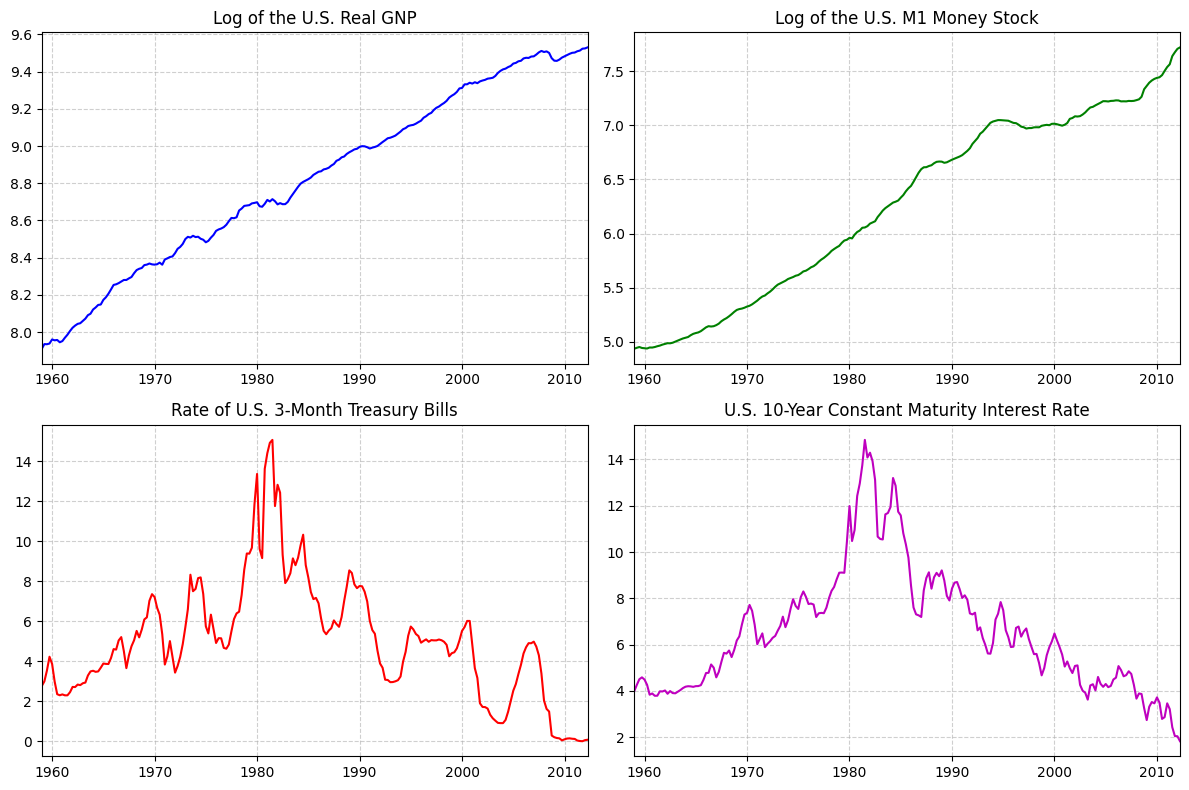

In [101]:
# Create a 2x2 subplot layout with an optimized figure size
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot Log of the U.S. real GNP
axes[0, 0].plot(usm['lrgnp'], color='b', linestyle='-')
axes[0, 0].set_title('Log of the U.S. Real GNP', fontsize=12)
axes[0, 0].grid(True, linestyle='--', alpha=0.6)
axes[0, 0].set_xlim(pd.to_datetime('1959-01-01'), pd.to_datetime('2012-04-01'))

# Plot Log of the U.S. M1 money stock
axes[0, 1].plot(usm['lm1sk'], color='g', linestyle='-')
axes[0, 1].set_title('Log of the U.S. M1 Money Stock', fontsize=12)
axes[0, 1].grid(True, linestyle='--', alpha=0.6)
axes[0, 1].set_xlim(pd.to_datetime('1959-01-01'), pd.to_datetime('2012-04-01'))


# Plot Rate of U.S. 3-month Treasury Bills
axes[1, 0].plot(usm['tb3m'], color='r', linestyle='-')
axes[1, 0].set_title('Rate of U.S. 3-Month Treasury Bills', fontsize=12)
axes[1, 0].grid(True, linestyle='--', alpha=0.6)
axes[1, 0].set_xlim(pd.to_datetime('1959-01-01'), pd.to_datetime('2012-04-01'))


# Plot U.S. 10-year constant maturity interest rate
axes[1, 1].plot(usm['gs10'], color='m', linestyle='-')
axes[1, 1].set_title('U.S. 10-Year Constant Maturity Interest Rate', fontsize=12)
axes[1, 1].grid(True, linestyle='--', alpha=0.6)
axes[1, 1].set_xlim(pd.to_datetime('1959-01-01'), pd.to_datetime('2012-04-01'))


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [102]:
# Perform an Ordinary Least Squares (OLS) regression
olsres = smf.ols('usm.lm1sk ~ usm.lrgnp', data=usm).fit()  # Regress log M1 money stock (lm1sk) on log real GNP (lrgnp)

# Print the regression summary
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:              usm.lm1sk   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     6521.
Date:                Tue, 11 Mar 2025   Prob (F-statistic):          3.52e-161
Time:                        15:29:10   Log-Likelihood:                 102.52
No. Observations:                 214   AIC:                            -201.0
Df Residuals:                     212   BIC:                            -194.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.0752      0.190    -47.673      0.0

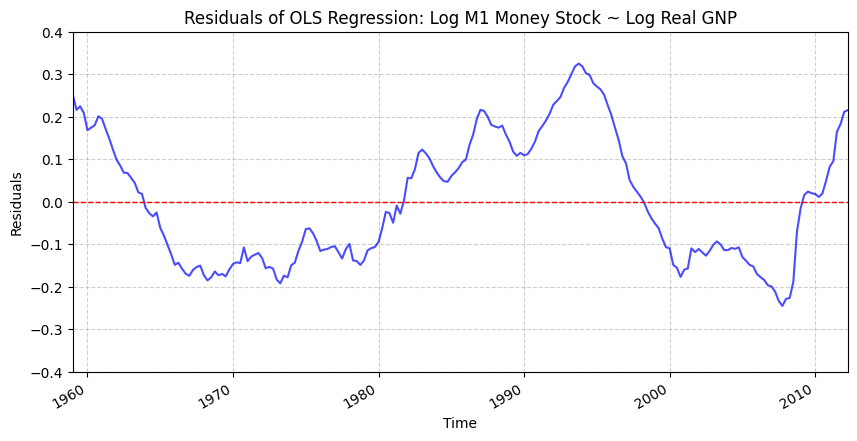

In [103]:
# Extract residuals from the OLS regression model
olsresid = olsres.resid  # Residuals represent the difference between observed and predicted values

# Create Graph
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(olsresid, linestyle='-', markersize=3, color='b', alpha=0.7)  
ax.axhline(y=0, color='red', linestyle='--', linewidth=1) 

ax.set_xlabel('Time')  
ax.set_ylabel('Residuals')
ax.set_title('Residuals of OLS Regression: Log M1 Money Stock ~ Log Real GNP') 
ax.grid(True, linestyle='--', alpha=0.6)  
ax.set_xlim(pd.to_datetime('1959-01-01'), pd.to_datetime('2012-04-01'))
ax.set_ylim(-0.4,0.4)

fig.autofmt_xdate()
plt.show()

In [104]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(olsresid, regression = 'ctt')  # 'ct' includes both trend and constant in the test

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -2.2052156508528835
p-value: 0.727451292412217

p-value > alpha; H0: Not Stationary


In [105]:
# Perform the KPSS test to check for stationarity
kpss_result = kpss(olsresid, regression='ct', nlags='auto')  # 'ct' includes both trend and constant in the test

# Extract relevant results from the KPSS test
kpss_stat = kpss_result[0]    # Test statistic
p_value = kpss_result[1]      # p-value for the test
lags_used = kpss_result[2]    # Number of lags used in the test

# Critical values at different significance levels (1%, 5%, 10%)
crit_values = kpss_result[3]  

# Print the results
print("\n=== KPSS Test Results ===")
print(f"KPSS Test Statistic: {kpss_stat:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"Number of Lags Used: {lags_used}")
print("\nCritical Values:")
for key, value in crit_values.items():
    print(f"  {key}: {value:.4f}")

# Interpretation of the results
if p_value < 0.05:
    print("\nConclusion: H0 is rejected → The series is NOT stationary.")
else:
    print("\nConclusion: Fail to reject H0 → The series is stationary at level.")


=== KPSS Test Results ===
KPSS Test Statistic: 0.2059
p-value: 0.013778
Number of Lags Used: 9

Critical Values:
  10%: 0.1190
  5%: 0.1460
  2.5%: 0.1760
  1%: 0.2160

Conclusion: H0 is rejected → The series is NOT stationary.


In [106]:
# Perform the Engle-Granger cointegration test between 'lrgnp' and 'lm1sk'
coint_result = coint(usm.lrgnp, usm.lm1sk, trend='c')  # 'c' includes a constant term in the test

# Extract test statistic, p-value, and critical values
coint_stat = coint_result[0]       # Cointegration test statistic
p_value = coint_result[1]          # p-value for significance testing
critical_values = coint_result[2]  # Critical values at different confidence levels

# Print the test results
print("\n=== Engle-Granger Cointegration Test ===")
print(f"Test Statistic: {coint_stat:.4f}")  
print(f"p-value: {p_value:.6f}")  

# Display critical values for comparison
print("\nCritical Values:")
for key, value in zip(["10%", "5%", "1%"], critical_values):
    print(f"  {key}: {value:.4f}")

# Interpretation of results
if p_value < 0.05:
    print("\nConclusion: Reject H0 → The series are cointegrated (long-run equilibrium exists).")
else:
    print("\nConclusion: Fail to Reject H0 → No evidence of cointegration (no long-run relationship).")


=== Engle-Granger Cointegration Test ===
Test Statistic: -2.3120
p-value: 0.367604

Critical Values:
  10%: -3.9486
  5%: -3.3650
  1%: -3.0644

Conclusion: Fail to Reject H0 → No evidence of cointegration (no long-run relationship).


In [107]:
# Compute first differences of the 'usm' dataset to remove potential trends and make it stationary
dusm = usm.diff(1).dropna()  # First-order differencing, dropping NaN values from the first row

# Rename columns to indicate they represent first differences
dusm.columns = ['dlrgnp',  # First difference of log U.S. real GNP
                'dtb3m',   # First difference of U.S. 3-month treasury bill rate
                'dgs10',   # First difference of U.S. 10-year constant maturity interest rate
                'dlm1sk']  # First difference of log U.S. M1 money stock

In [108]:
# Perform the KPSS test on the first-differenced log U.S. real GNP series
kpss_result = kpss(dusm.dlrgnp,      # The first-differenced log U.S. real GNP series
                    regression='c',  # Use 'c' for a model with a constant term
                    nlags='auto')    # Automatically determine the number of lags

# Display the test result
print("KPSS Test Statistic:", kpss_result[0])  
print("p-value:", kpss_result[1])  
print("Lags Used:", kpss_result[2])  
print("Critical Values:", kpss_result[3])

# Interpretation of the test
if kpss_result[1] < 0.05:
    print("\nConclusion: The series is not stationary (H₀ rejected at 5% significance level).")
else:
    print("\nConclusion: Fail to reject H₀, the series is likely stationary.")

KPSS Test Statistic: 0.38679767962152906
p-value: 0.08284582774934092
Lags Used: 6
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

Conclusion: Fail to reject H₀, the series is likely stationary.


In [109]:
# Perform the Augmented Dickey-Fuller (ADF) test on the first-differenced log U.S. real GNP series
adf_result = adfuller(dusm.dlrgnp,     # The first-differenced log U.S. real GNP series
                      regression='c')  # Use 'c' for a model with a constant term

# Display ADF test results
print("ADF Test Statistic:", adf_result[0])  
print("p-value:", adf_result[1])  
print("Number of Lags Used:", adf_result[2])  
print("Number of Observations Used:", adf_result[3])  
print("Critical Values:", adf_result[4])

# Interpretation of the test
if adf_result[1] < 0.05:
    print("\nConclusion: The series is stationary (H₀ rejected at 5% significance level).")
else:
    print("\nConclusion: Fail to reject H₀, the series is not stationary.")

ADF Test Statistic: -7.0629855568288304
p-value: 5.165957446457406e-10
Number of Lags Used: 1
Number of Observations Used: 211
Critical Values: {'1%': -3.46172743446274, '5%': -2.8753374677799957, '10%': -2.574124089081557}

Conclusion: The series is stationary (H₀ rejected at 5% significance level).


In [110]:
# Perform the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test on the first-differenced log M1 money stock series
kpss_result = kpss(dusm.dlm1sk,      # The first-differenced log M1 money stock series
                    regression='c',  # Use 'c' for a model with a constant term
                    nlags='auto')    # Automatically determine the number of lags

# Display KPSS test results
print("KPSS Test Statistic:", kpss_result[0])  
print("p-value:", kpss_result[1])  
print("Number of Lags Used:", kpss_result[2])  
print("Critical Values:", kpss_result[3])

# Interpretation of the test
if kpss_result[1] < 0.05:
    print("\nConclusion: The series is non-stationary (H₀ rejected at 5% significance level).")
else:
    print("\nConclusion: Fail to reject H₀, the series is stationary.")

KPSS Test Statistic: 0.1414977254111999
p-value: 0.1
Number of Lags Used: 8
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

Conclusion: Fail to reject H₀, the series is stationary.


In [111]:
# Perform the Augmented Dickey-Fuller (ADF) test on the first-differenced log M1 money stock series
adf_result = adfuller(dusm.dlm1sk,     # The first-differenced log M1 money stock series
                      regression='c')  # Use 'c' for a model with a constant term

# Display ADF test results
print("ADF Test Statistic:", adf_result[0])  
print("p-value:", adf_result[1])  
print("Number of Lags Used:", adf_result[2])  
print("Number of Observations:", adf_result[3])  
print("Critical Values:", adf_result[4])

# Interpretation of the test
if adf_result[1] < 0.05:
    print("\nConclusion: The series is stationary (H₀ rejected at 5% significance level).")
else:
    print("\nConclusion: Fail to reject H₀, the series is non-stationary.")

ADF Test Statistic: -3.4353955048351157
p-value: 0.00980981972925084
Number of Lags Used: 11
Number of Observations: 201
Critical Values: {'1%': -3.4633090972761744, '5%': -2.876029332045744, '10%': -2.5744932593252643}

Conclusion: The series is stationary (H₀ rejected at 5% significance level).


In [112]:
# Perform an Ordinary Least Squares (OLS) regression to model the relationship 
# between the first-differenced log M1 money stock and first-differenced log real GDP
olsres2 = smf.ols('dusm.dlm1sk ~ dusm.dlrgnp',  # Dependent and independent variables
                  data=dusm).fit()              # Fit the model using the differenced data

# Print the summary of the OLS regression results
print(olsres2.summary())

                            OLS Regression Results                            
Dep. Variable:            dusm.dlm1sk   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.678
Date:                Tue, 11 Mar 2025   Prob (F-statistic):              0.197
Time:                        15:29:10   Log-Likelihood:                 625.39
No. Observations:                 213   AIC:                            -1247.
Df Residuals:                     211   BIC:                            -1240.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0141      0.001     12.042      